Notebook dedicado ao treinamento e teste do modelo XGBoost aplicado aos 22 criptoativos escolhidos.
Modificações nesta revisão:
- Diminuir as janelas das variáveis que possuem médias móveis: as coisas acontecem muito mais rápido com as cryptos do que com ações;
- Fazer um plot_acf para avaliar correlação temporal de cada ativo consigo mesmo

# 1. Bibliotecas e Constantes

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

#Biblioteca de otimização para Processadores Intel! Caso contrario, comentar.
#from sklearnex import patch_sklearn
#patch_sklearn()

from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.pipeline import Pipeline

import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import xgboost as xgb
from xgboost import plot_importance

from boruta import BorutaPy
from joblib import dump, load

In [2]:
horizonte = 10 #horizonte da previsão, em dias.

# 2. Preparação de dados

In [3]:
#Alterando caminho para pasta comum
df_ativos = pd.read_csv("../dados/df_ativos/df_ativos_raw.csv", index_col=0)
df_ativos.sort_index(inplace=True) #Organizando o df por datas
df_ativos.drop(columns = 'Adj Close', inplace=True)
df_ativos

Ativo         Open         High          Low        Close  \
2014-09-17   BTC-USD   465.864014   468.174011   452.421997   457.334015   
2014-09-17  DOGE-USD     0.000293     0.000299     0.000260     0.000268   
2014-09-17   XMR-USD     1.841200     1.898070     1.647920     1.768350   
2014-09-17   LTC-USD     5.085890     5.170770     4.965950     5.058550   
2014-09-17  DASH-USD     3.327650     3.878730     3.297880     3.753940   
...              ...          ...          ...          ...          ...   
2021-08-20   XLM-USD     0.366957     0.387311     0.360759     0.385290   
2021-08-20   BNB-USD   430.975037   457.603729   422.080170   454.936310   
2021-08-20  LINK-USD    27.060467    28.979713    26.707174    28.701841   
2021-08-20   MKR-USD  3745.071533  3850.748535  3705.013672  3813.081787   
2021-08-20  DASH-USD   219.971161   235.317276   218.387054   232.825378   

                Volume  
2014-09-17    21056800  
2014-09-17     1463600  
2014-09-17      291633  
2014-09-17     3071840  
2014-09-17      574556  
...                ...  
2021-08-20   780181594  
2021-08-20  2451578694  
2021-08-20  1751490161  
2021-08-20   145465521  
2021-08-20   502645254  

[41303 rows x 6 columns]

Vamos fazer um pequeno check de consistência nos dados:

In [4]:
df_ativos.isna().sum()

Ativo     0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Nenhum dado nulo no dataframe.

In [5]:
df_ativos.groupby(['Ativo']).count()

Open  High   Low  Close  Volume
Ativo                                     
ADA-USD    1415  1415  1415   1415    1415
BCH-USD    1486  1486  1486   1486    1486
BNB-USD    1484  1484  1484   1484    1484
BTC-USD    2526  2526  2526   2526    2526
DASH-USD   2526  2526  2526   2526    2526
DOGE-USD   2526  2526  2526   2526    2526
EOS-USD    1508  1508  1508   1508    1508
ETC-USD    1850  1850  1850   1850    1850
ETH-USD    2202  2202  2202   2202    2202
FIL-USD    1185  1185  1185   1185    1185
LINK-USD   1426  1426  1426   1426    1426
LTC-USD    2526  2526  2526   2526    2526
MIOTA-USD  1526  1526  1526   1526    1526
MKR-USD    1229  1229  1229   1229    1229
NEO-USD    1803  1803  1803   1803    1803
THETA-USD  1305  1305  1305   1305    1305
TRX-USD    1434  1434  1434   1434    1434
USDT-USD   2353  2353  2353   2353    2353
XLM-USD    2526  2526  2526   2526    2526
XMR-USD    2526  2526  2526   2526    2526
XRP-USD    2526  2526  2526   2526    2526
XTZ-USD    1415  1415  1415   1415    1415

Nem todos os ativos apresentam cotação para todo o período. Porém há dados que cobrem razoável parte do espectro temporal para cada ativo. Não obstante, alguns ativos mais recentes, como o ICP1, não poderão ser analisados pelo curto prazo de dados.

Vamos criar uma lista com o nome dos ativos, para facilitar as iterações futuras:

In [6]:
ativos = list(df_ativos['Ativo'].unique())
ativos

['BTC-USD',
 'DOGE-USD',
 'XMR-USD',
 'LTC-USD',
 'DASH-USD',
 'XLM-USD',
 'XRP-USD',
 'USDT-USD',
 'ETH-USD',
 'ETC-USD',
 'NEO-USD',
 'MKR-USD',
 'MIOTA-USD',
 'EOS-USD',
 'BCH-USD',
 'BNB-USD',
 'TRX-USD',
 'LINK-USD',
 'ADA-USD',
 'XTZ-USD',
 'FIL-USD',
 'THETA-USD']

## Nos inspiramos em um paper ([Link](https://sci-hub.se/10.1016/j.asoc.2020.106943 "Artigo")) que traz uma série de dados de entrada, que vamos preparar na sequência. São eles:

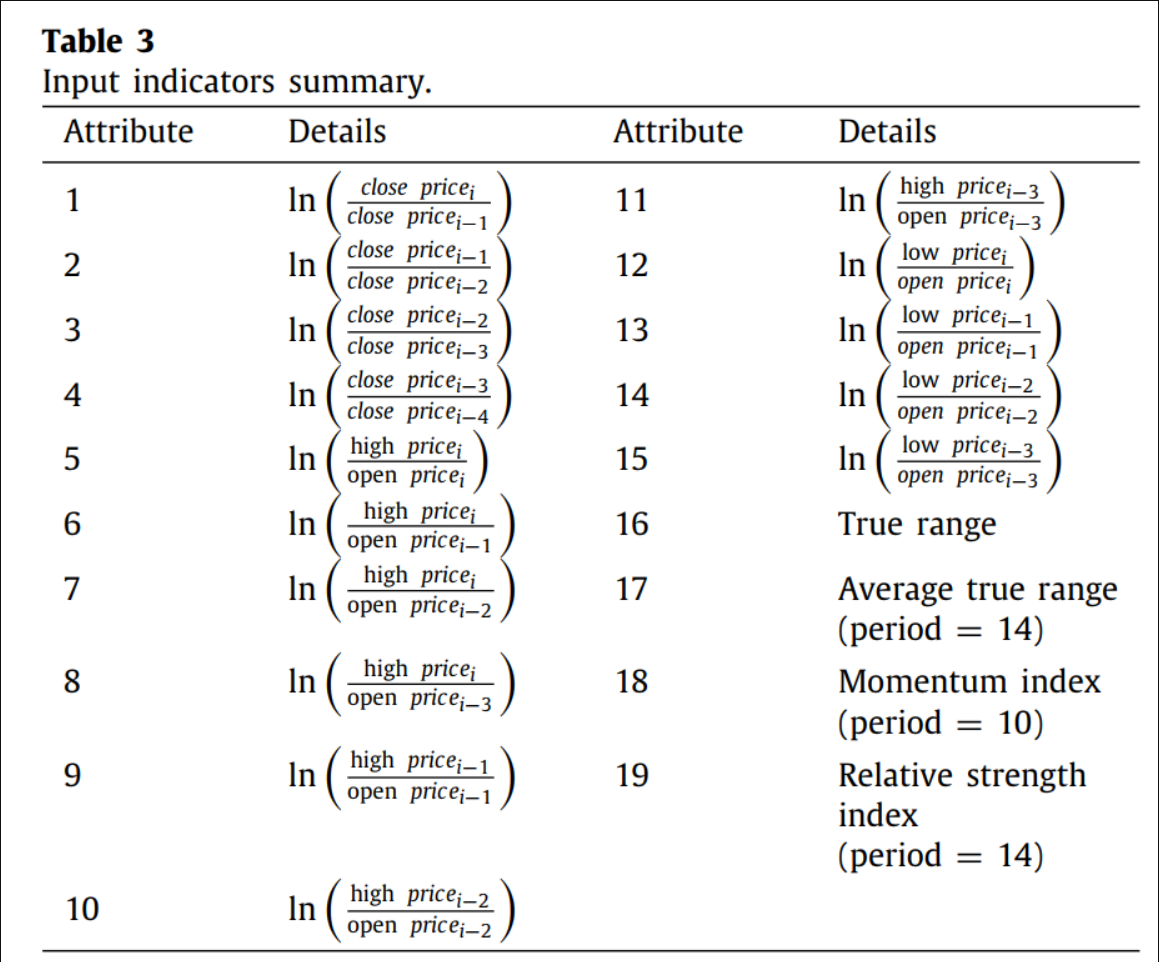

Como se pode observar, são 15 variáveis que envolvem relações temporais entre preços (open, high, low, close), além de 4 outras features muito utilizadas (True Range, Average True Range | 14d, Momentum Index | 10d, Relative Strength Index | 14d).

Na sequência, vamos criar todas essas varíaveis com base nos dados já levantados. Siglas:

* O - Open Price para um dia *"i"* específico
* H - Highest Price para um dia *"i"* específico
* L - Lowest Price para um dia *"i"* específico
* C - Close Price para um dia *"i"* específico

In [7]:
#Função para calcular RSI: [Créditos para https://www.kaggle.com/mtszkw/xgboost-for-stock-trend-prices-prediction, levemente modificado para comportar diversos ativos]

def relative_strength_idx(df, ativo, n): #MUDAR PARAM "n" AQUI PARA VARIAR A MÉDIA MÓVEL
    close = df[df['Ativo']==ativo]['Close']
    delta = close.diff()
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [8]:
df_ativos['1: ln(C/C-1)'] = pd.Series(dtype=float)
df_ativos['2: ln(C-1/C-2)'] = pd.Series(dtype=float)
df_ativos['3: ln(C-2/C-3)'] = pd.Series(dtype=float)
df_ativos['4: ln(C-3/C-4)'] = pd.Series(dtype=float)
df_ativos['5: ln(H/O)'] = pd.Series(dtype=float)
df_ativos['6: ln(H/O-1)'] = pd.Series(dtype=float)
df_ativos['7: ln(H/O-2)'] = pd.Series(dtype=float)
df_ativos['8: ln(H/O-3)'] = pd.Series(dtype=float)
df_ativos['9: ln(H-1/O-1)'] = pd.Series(dtype=float)
df_ativos['10: ln(H-2/O-2)'] = pd.Series(dtype=float)
df_ativos['11: ln(H-3/O-3)'] = pd.Series(dtype=float)
df_ativos['12: ln(L/O)'] = pd.Series(dtype=float)
df_ativos['13: ln(L-1/O-1)'] = pd.Series(dtype=float)
df_ativos['14: ln(L-2/O-2)'] = pd.Series(dtype=float)
df_ativos['15: ln(L-3/O-3)'] = pd.Series(dtype=float)
df_ativos['16: True Range'] = pd.Series(dtype=float)
df_ativos['17: ATR 5d'] = pd.Series(dtype=float)
df_ativos['17b: ATR 10d'] = pd.Series(dtype=float)
df_ativos['17c: ATR 14d'] = pd.Series(dtype=float)
df_ativos['18: MI 3d'] = pd.Series(dtype=float)
df_ativos['18b: MI 7d'] = pd.Series(dtype=float)
df_ativos['19: RSI 5d'] = pd.Series(dtype=float)
df_ativos['19b: RSI 10d'] = pd.Series(dtype=float)
df_ativos['19c: RSI 14d'] = pd.Series(dtype=float)
df_ativos['20: ln(Vol/Vol-1)'] = pd.Series(dtype=float)
df_ativos['21: ln(Vol-1/Vol-2)'] = pd.Series(dtype=float)


for ativo in ativos:
    
    df_ativos.loc[df_ativos['Ativo'] == ativo,'1: ln(C/C-1)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'] / df_ativos.loc[df_ativos['Ativo'] == ativo,'Close'].shift(1))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'2: ln(C-1/C-2)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(1)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(2))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'3: ln(C-2/C-3)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(2)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(3))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'4: ln(C-3/C-4)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(3)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(4))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'5: ln(H/O)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High']/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'])
    df_ativos.loc[df_ativos['Ativo'] == ativo,'6: ln(H/O-1)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High']/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(1))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'7: ln(H/O-2)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High']/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(2))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'8: ln(H/O-3)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High']/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(3))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'9: ln(H-1/O-1)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High'].shift(1)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(1))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'10: ln(H-2/O-2)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High'].shift(2)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(2))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'11: ln(H-3/O-3)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High'].shift(3)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(3))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'12: ln(L/O)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Low']/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'])
    df_ativos.loc[df_ativos['Ativo'] == ativo,'13: ln(L-1/O-1)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Low'].shift(1)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(1))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'14: ln(L-2/O-2)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Low'].shift(2)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(2))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'15: ln(L-3/O-3)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Low'].shift(3)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(3))
    
    
    df_ativos.loc[df_ativos['Ativo'] == ativo,'16: True Range'] = np.nanmax([np.abs(df_ativos.loc[df_ativos['Ativo'] == ativo, 'High'] - df_ativos.loc[df_ativos['Ativo'] == ativo, 'Low']), 
                                                                            np.abs(df_ativos.loc[df_ativos['Ativo'] == ativo, 'High'] - df_ativos.loc[df_ativos['Ativo'] == ativo, 'Close'].shift(1)), 
                                                                            np.abs(df_ativos.loc[df_ativos['Ativo'] == ativo, 'Low'] - df_ativos.loc[df_ativos['Ativo'] == ativo, 'Close'].shift(1))], axis=0)
    
    
    df_ativos.loc[df_ativos['Ativo'] == ativo,'17: ATR 5d'] = df_ativos.loc[df_ativos['Ativo'] == ativo,'16: True Range'].rolling(window=5).mean()
    df_ativos.loc[df_ativos['Ativo'] == ativo,'17b: ATR 10d'] = df_ativos.loc[df_ativos['Ativo'] == ativo,'16: True Range'].rolling(window=10).mean()
    df_ativos.loc[df_ativos['Ativo'] == ativo,'17c: ATR 14d'] = df_ativos.loc[df_ativos['Ativo'] == ativo,'16: True Range'].rolling(window=14).mean()
    
    df_ativos.loc[df_ativos['Ativo'] == ativo,'18: MI 3d'] = df_ativos.loc[df_ativos['Ativo'] == ativo, 'Close'] - df_ativos.loc[df_ativos['Ativo'] == ativo, 'Close'].shift(3)
    df_ativos.loc[df_ativos['Ativo'] == ativo,'18b: MI 7d'] = df_ativos.loc[df_ativos['Ativo'] == ativo, 'Close'] - df_ativos.loc[df_ativos['Ativo'] == ativo, 'Close'].shift(7)

    df_ativos.loc[df_ativos['Ativo'] == ativo,'19: RSI 5d'] = relative_strength_idx(df_ativos,ativo, n=5)
    df_ativos.loc[df_ativos['Ativo'] == ativo,'19b: RSI 10d'] = relative_strength_idx(df_ativos,ativo, n=10)
    df_ativos.loc[df_ativos['Ativo'] == ativo,'19c: RSI 14d'] = relative_strength_idx(df_ativos,ativo, n=14)
    
    df_ativos.loc[df_ativos['Ativo'] == ativo,'20: ln(Vol/Vol-1)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo, 'Volume'] / df_ativos.loc[df_ativos['Ativo'] == ativo,'Volume'].shift(1))
    
    df_ativos.loc[df_ativos['Ativo'] == ativo,'21: ln(Vol-1/Vol-2)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo, 'Volume'].shift(1) / df_ativos.loc[df_ativos['Ativo'] == ativo,'Volume'].shift(2))

    #Como a ideia é prever o preço do dia seguinte, vamos dar um shift na coluna 'Close' para o horizonte requerido:
    df_ativos.loc[df_ativos['Ativo'] == ativo,'Close'] = df_ativos.loc[df_ativos['Ativo'] == ativo, 'Close'].shift(-horizonte)
    
df_ativos.dropna(inplace=True)
df_ativos.drop(columns = ['Open', 'High', 'Low'], inplace=True) #Dropando colunas inúteis.

df_ativos

Ativo       Close      Volume  1: ln(C/C-1)  2: ln(C-1/C-2)  \
2014-10-01    XMR-USD    1.076710       65140     -0.016527        0.059606   
2014-10-01    BTC-USD  362.299011    26229400     -0.008641        0.030109   
2014-10-01    LTC-USD    3.772660     1172180     -0.010372        0.052283   
2014-10-01    XRP-USD    0.004753       64998      0.022989       -0.013050   
2014-10-01    XLM-USD    0.002336       70180     -0.108792       -0.000311   
...               ...         ...         ...           ...             ...   
2021-08-10  THETA-USD    7.277748   313640625      0.022782        0.055899   
2021-08-10    FIL-USD   73.149849   621114680     -0.015608        0.049901   
2021-08-10    XLM-USD    0.385290   685222152      0.035555        0.040420   
2021-08-10    XMR-USD  281.944458   228553925     -0.014969        0.050606   
2021-08-10    BCH-USD  693.681641  2207047184     -0.000177        0.063391   

            3: ln(C-2/C-3)  4: ln(C-3/C-4)  5: ln(H/O)  6: ln(H/O-1)  \
2014-10-01       -0.059705       -0.068457    0.008003      0.045624   
2014-10-01       -0.004555       -0.057539    0.010149      0.039853   
2014-10-01        0.003198       -0.043582    0.007305      0.057474   
2014-10-01       -0.115679        0.115679    0.026974      0.014140   
2014-10-01        0.011901       -0.027654    0.019066      0.017205   
...                    ...             ...         ...           ...   
2021-08-10       -0.078676        0.008999    0.046528      0.101348   
2021-08-10       -0.071522        0.076856    0.028505      0.076606   
2021-08-10       -0.063779        0.072823    0.050259      0.090640   
2021-08-10       -0.053536        0.029749    0.003860      0.051646   
2021-08-10       -0.047461        0.046838    0.023661      0.086141   

            7: ln(H/O-2)  ...  17: ATR 5d  17b: ATR 10d  17c: ATR 14d  \
2014-10-01     -0.002255  ...    0.101220      0.127626      0.170490   
2014-10-01      0.037622  ...   15.407996     17.614697     22.595568   
2014-10-01      0.060904  ...    0.184038      0.232394      0.276422   
2014-10-01     -0.100971  ...    0.000364      0.000261      0.000272   
2014-10-01      0.035026  ...    0.000353      0.000457      0.000551   
...                  ...  ...         ...           ...           ...   
2021-08-10      0.022183  ...    0.588351      0.574432      0.546775   
2021-08-10      0.005017  ...    6.289270      4.915404      4.128175   
2021-08-10      0.023069  ...    0.022158      0.020179      0.019635   
2021-08-10     -0.002090  ...   15.638623     16.262886     15.807799   
2021-08-10      0.037730  ...   36.002234     34.559821     33.628416   

            18: MI 3d  18b: MI 7d  19: RSI 5d  19b: RSI 10d  19c: RSI 14d  \
2014-10-01  -0.020110   -0.305760   21.528366     44.702402     26.377827   
2014-10-01   6.433990  -39.589996   26.224741     43.217649     31.461697   
2014-10-01   0.195330   -0.238230   49.484647     56.977367     35.151758   
2014-10-01  -0.000530    0.000084   54.815851     55.176337     37.495167   
2014-10-01  -0.000294   -0.001010   37.351198     36.751362     47.186400   
...               ...         ...         ...           ...           ...   
2021-08-10   0.000035    1.038108   44.276589     63.879250     63.521194   
2021-08-10  -2.530663   12.540874   71.609488     77.099052     78.580838   
2021-08-10   0.003758    0.035849   71.943048     64.268267     71.750600   
2021-08-10  -4.807037   40.976334   63.420668     64.096207     67.960800   
2021-08-10   9.258118   55.390137   72.327228     64.591491     71.641245   

            20: ln(Vol/Vol-1)  21: ln(Vol-1/Vol-2)  
2014-10-01          -0.231326            -0.021785  
2014-10-01          -0.280069             0.065781  
2014-10-01          -0.739840             0.360663  
2014-10-01          -0.520216            -0.110047  
2014-10-01           1.200322            -0.441454  
...                       ...                  ...  
2021-08-10          -0.092111

<AxesSubplot:>

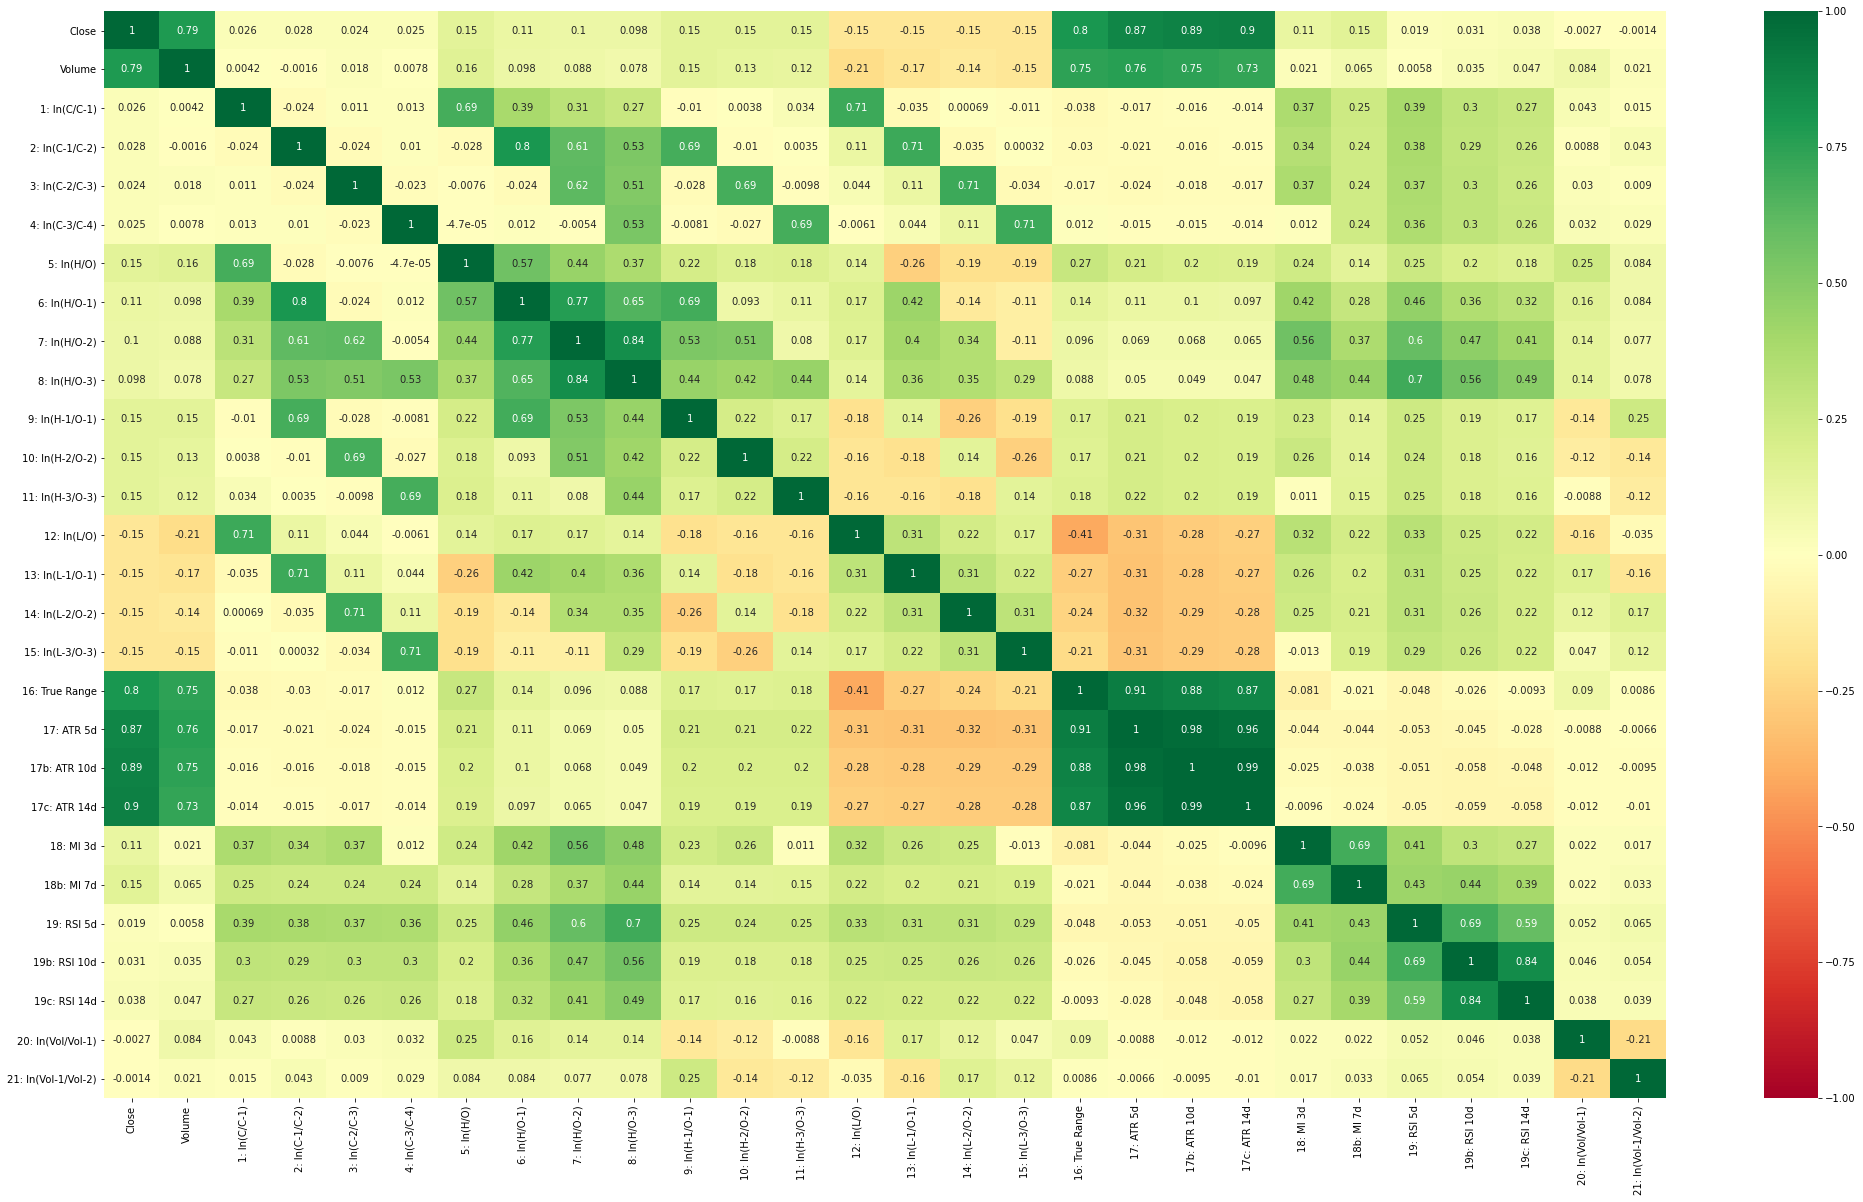

In [9]:
fig,ax = plt.subplots(figsize = (35,20))
sns.heatmap(df_ativos[df_ativos.Ativo == 'BTC-USD'].corr(),vmin=-1,vmax=1,annot=True,cmap="RdYlGn")

In [10]:
# Adequando pasta de salvamento, para não ficar no máquina Local
df_ativos.to_csv("..\Dados\df_ativos\df_ativos_processed_rev4.csv", index = True)

# 3. Função para treinamento, validação, tunning, teste e armazenamento dos modelos para cada ativo

In [11]:
def model_crypto(ativo, df_ativos, df_models):

    #1. Split treino+validação / teste:
    
    
    test_size = 0.05
    test_split_idx  = int(df_ativos[df_ativos['Ativo']==ativo].shape[0] * (1-test_size))

    df_train  = df_ativos[df_ativos['Ativo']==ativo].iloc[:test_split_idx].copy()
    df_test   = df_ativos[df_ativos['Ativo']==ativo].iloc[test_split_idx+1:].copy()

    X_train = df_train.drop(columns=['Close','Ativo']) #df_train[lista_boruta]
    X_test = df_test.drop(columns=['Close','Ativo']) #df_test[lista_boruta]

    y_train = df_train['Close']
    y_test = df_test['Close']
    
    
    #2. Modelo e tunning com validação baseada em TimeSeriesSplit: 
    model = xgb.XGBRegressor()
    print (f"\nIniciando tunning do modelo para {ativo}")
    param_search = {
    'learning_rate': [0.3, 0.5], #ok
    'n_estimators': [50, 100, 400], #ok 
    'max_depth': [3, 4, 5], #ok
    'subsample': [0.8, 1], #ok
    'colsample_bytree': [0.5, 0.8, 1], #ok 
    #'model__colsample_bylevel': [0.5, 0.7, 0.9], #ok
    'min_child_weight': [0.5, 5, 10], # https://kevinvecmanis.io/machine%20learning/hyperparameter%20tuning/dataviz/python/2019/05/11/XGBoost-Tuning-Visual-Guide.html#child_weight
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 1e-4, 1e-2], #ok 
    'reg_lambda': [1e-4, 1e-2, 1], #ok
    'random_state': [248]
}

    tscv = TimeSeriesSplit(n_splits=4)

    halving_cv = HalvingGridSearchCV(model, param_search, scoring='neg_mean_squared_error', n_jobs=-1, min_resources=200, factor=3, cv = tscv, verbose = 4)

    halving_cv.fit(X_train, y_train)
    
    model_best = halving_cv.best_estimator_
    
    print (f"\nMelhor modelo escolhido com os parâmetros:")
    print(halving_cv.best_params_)
    
    #3. Predição, gráficos e feature importance:
    
    y_pred = model_best.predict(X_test)
    y_total = model_best.predict(df_ativos[df_ativos['Ativo']==ativo].drop(columns = ['Ativo','Close']))
    
    fig = go.Figure(layout=go.Layout(title=go.layout.Title(text=ativo))) 
    fig.add_trace(go.Scatter(x=X_train.index, y=y_train, name='Treino'))
    fig.add_trace(go.Scatter(x=X_test.index,  y=y_test,  name='Teste'))
    fig.add_trace(go.Scatter(x=df_ativos[df_ativos['Ativo']==ativo].index,  y=y_total,  name='Pred'))
    fig.show()
    
    print (f"\nFeature importance para {ativo}:")
    plt.rcParams["figure.figsize"] = (20, 10)
    plot_importance(model_best)
    plt.show()
    
    #4. Métricas de erro no teste:
    
    MAPE_test = np.mean(np.abs((y_test - y_pred)/y_test))
    MSE_test = mean_squared_error(y_true = y_test, y_pred = y_pred, squared = False)
    MAE_test = mean_absolute_error(y_true = y_test, y_pred = y_pred)
    RMSE_test = mean_squared_error(y_true = y_test, y_pred = y_pred, squared = True)

    print(f"\nResultados do modelo no teste para {ativo}")
    print(f'MAPE = {MAPE_test:.4f}')
    print(f'MSE = {MSE_test:.4f}')
    print(f'MAE = {MAE_test:.4f}')
    print(f'RMSE = {RMSE_test:.4f}')
    
    #5. Armazenamento de parâmetros e métricas em dataframe:
    
    params_results = [ativo]
        
    cols_params = ['learning_rate', 'n_estimators', 'max_depth', 'subsample', 'colsample_bytree', 'min_child_weight', 'gamma', 'reg_alpha', 'reg_lambda'] 
    cols_results = ['MAPE_test', 'MSE_test', 'MAE_test', 'RMSE_test']
    
    
    for i in range(len(cols_params)):
        
        params_results.append(model_best.get_params()[cols_params[i]])
    
    params_results.extend([MAPE_test, MSE_test, MAE_test, RMSE_test])
    
    df_models.loc[len(df_models)] = params_results
    print ("DataFrame consolidado de melhores parâmetros e resultados por ativo até aqui:")
    
    print(df_models)
    
    print ("\n")    
    #Salvando o DF models
    df_models.to_csv("..\Modelos\df_models.csv")
        
    #6. Salvando o modelo:
    
    nome_modelo = 'modelo_' + str(ativo) + 'rev4.joblib' #Alterar revisão para salvar e não causar overwriting.
    dump(model_best, nome_modelo)
    print (f"\n{nome_modelo} salvo com sucesso!")
    

In [12]:
#Gerando df para armazenar os parâmetros e as métricas de cada modelo, a ser passado como argumento na função model_crypto:

cols_params=['Ativo', 'learning_rate', 'n_estimators', 'max_depth', 'subsample', 'colsample_bytree', 'min_child_weight', 'gamma', 'reg_alpha', 'reg_lambda'] 
cols_results = ['MAPE_test', 'MSE_test', 'MAE_test', 'RMSE_test']
cols_params.extend(cols_results)
df_models_rev4 = pd.DataFrame(columns = cols_params)
df_models_rev4

Empty DataFrame
Columns: [Ativo, learning_rate, n_estimators, max_depth, subsample, colsample_bytree, min_child_weight, gamma, reg_alpha, reg_lambda, MAPE_test, MSE_test, MAE_test, RMSE_test]
Index: []

# 4. Apresentação dos resultados para cada Ativo, com armazenamento dos modelos através do joblib e report de parâmetros e métricas para cada ativo em df


Iniciando tunning do modelo para BTC-USD
n_iterations: 3
n_required_iterations: 9
n_possible_iterations: 3
min_resources_: 200
max_resources_: 2376
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8748
n_resources: 200
Fitting 4 folds for each of 8748 candidates, totalling 34992 fits
----------
iter: 1
n_candidates: 2916
n_resources: 600
Fitting 4 folds for each of 2916 candidates, totalling 11664 fits
----------
iter: 2
n_candidates: 972
n_resources: 1800
Fitting 4 folds for each of 972 candidates, totalling 3888 fits

Melhor modelo escolhido com os parâmetros:
{'colsample_bytree': 0.5, 'gamma': 5, 'learning_rate': 0.5, 'max_depth': 5, 'min_child_weight': 0.5, 'n_estimators': 50, 'random_state': 248, 'reg_alpha': 0.01, 'reg_lambda': 0.0001, 'subsample': 0.8}



Feature importance para BTC-USD:


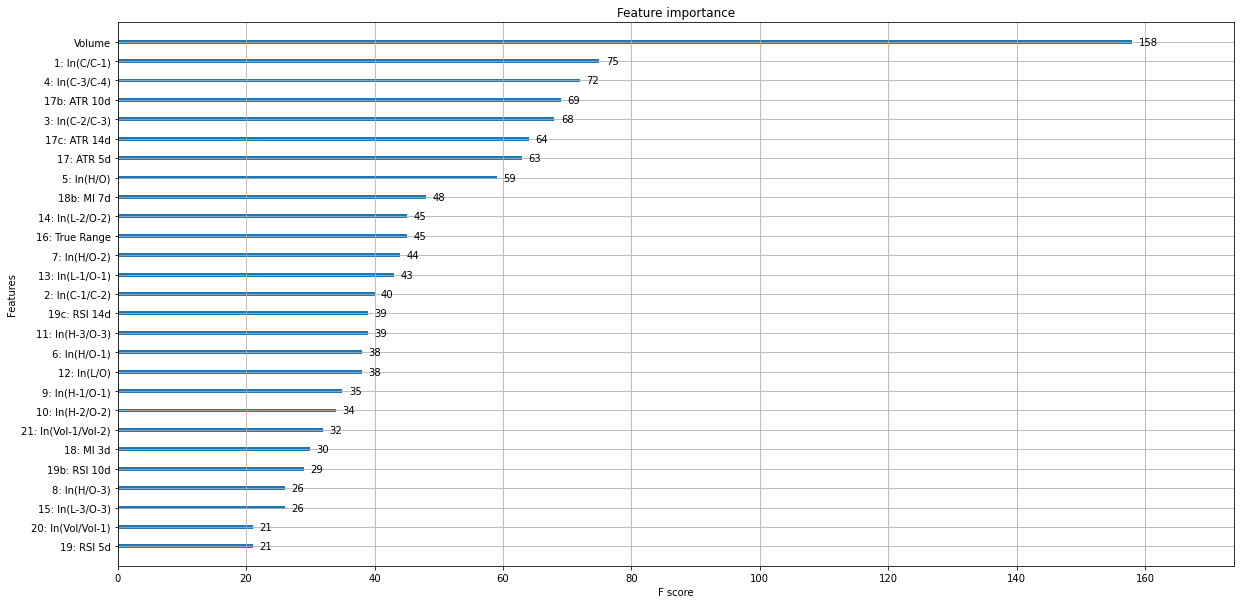


Resultados do modelo no teste para BTC-USD
MAPE = 0.2809
MSE = 13151.4100
MAE = 10828.7932
RMSE = 172959584.7549
DataFrame consolidado de melhores parâmetros e resultados por ativo até aqui:
     Ativo  learning_rate n_estimators max_depth  subsample  colsample_bytree  \
0  BTC-USD            0.5           50         5        0.8               0.5   

   min_child_weight gamma  reg_alpha  reg_lambda  MAPE_test      MSE_test  \
0               0.5     5       0.01      0.0001     0.2809  13151.409991   

      MAE_test     RMSE_test  
0  10828.79318  1.729596e+08  



modelo_BTC-USDrev4.joblib salvo com sucesso!

Iniciando tunning do modelo para DOGE-USD
n_iterations: 3
n_required_iterations: 9
n_possible_iterations: 3
min_resources_: 200
max_resources_: 2376
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8748
n_resources: 200
Fitting 4 folds for each of 8748 candidates, totalling 34992 fits


KeyboardInterrupt: 

In [13]:
for crypto in ativos:
    model_crypto(crypto, df_ativos, df_models_rev4)


Iniciando tunning do modelo para ETH-USD
n_iterations: 3
n_required_iterations: 9
n_possible_iterations: 3
min_resources_: 200
max_resources_: 2069
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8748
n_resources: 200
Fitting 4 folds for each of 8748 candidates, totalling 34992 fits
----------
iter: 1
n_candidates: 2916
n_resources: 600
Fitting 4 folds for each of 2916 candidates, totalling 11664 fits
----------
iter: 2
n_candidates: 972
n_resources: 1800
Fitting 4 folds for each of 972 candidates, totalling 3888 fits

Melhor modelo escolhido com os parâmetros:
{'colsample_bytree': 1, 'gamma': 5, 'learning_rate': 0.3, 'max_depth': 4, 'min_child_weight': 0.5, 'n_estimators': 50, 'random_state': 248, 'reg_alpha': 0.0001, 'reg_lambda': 0.0001, 'subsample': 0.8}


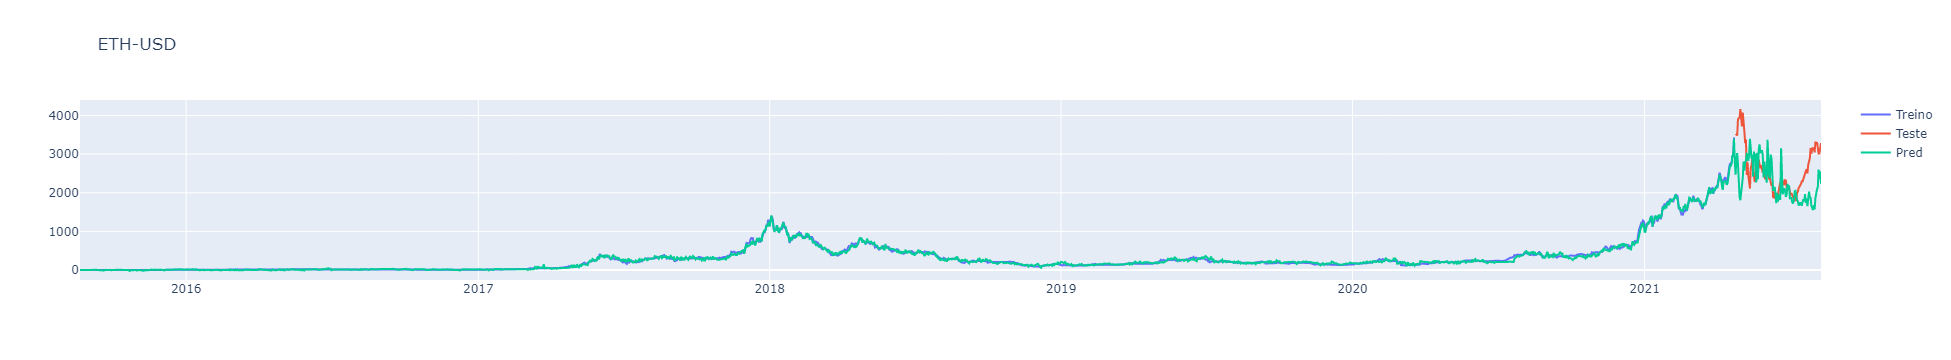


Feature importance para ETH-USD:


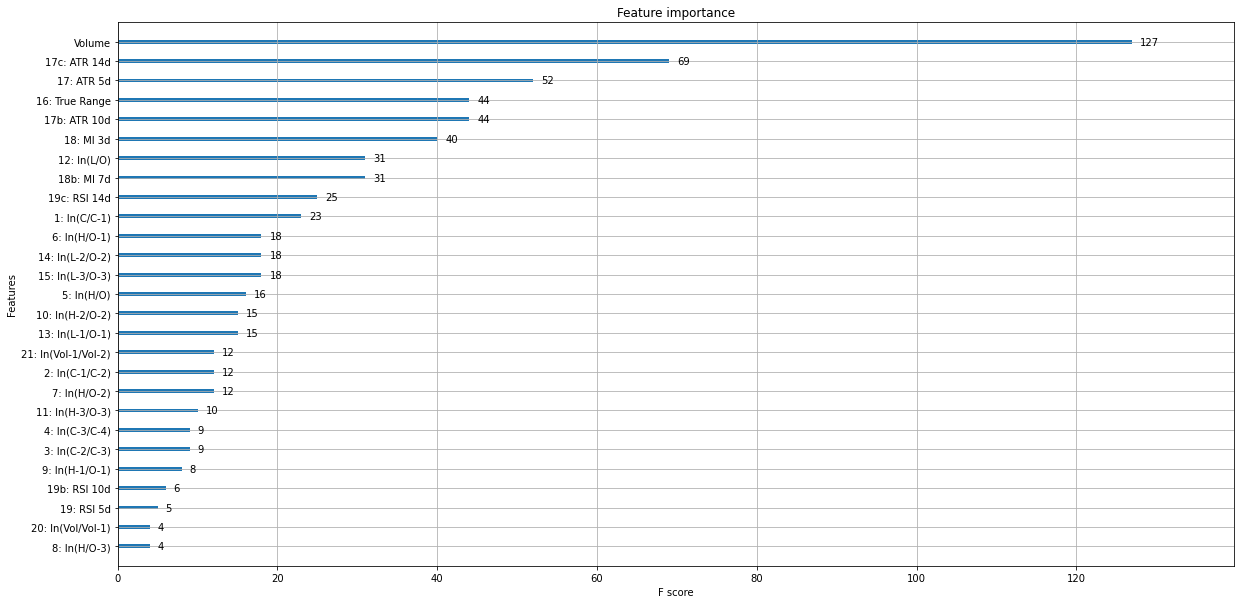


Resultados do modelo no teste para ETH-USD
MAPE = 0.2100
MSE = 780.3736
MAE = 596.2656
RMSE = 608982.9498
DataFrame consolidado de melhores parâmetros e resultados por ativo até aqui:
       Ativo  learning_rate n_estimators max_depth  subsample  \
0    BTC-USD            0.5          400         3        0.8   
1   DOGE-USD            0.5          400         3        0.8   
2    XMR-USD            0.5          400         3        0.8   
3    LTC-USD            0.5           50         3        1.0   
4   DASH-USD            0.5          400         4        0.8   
5    XLM-USD            0.5           50         3        0.8   
6    XRP-USD            0.5           50         3        0.8   
7   USDT-USD            0.3           50         6        1.0   
8    ETH-USD            0.5          100         6        1.0   
9    ETC-USD            0.3          400         6        1.0   
10   ETH-USD            0.3           50         4        0.8   

    colsample_bytree min_child_wei

KeyboardInterrupt: 

In [ ]:
for crypto in ativos[8:]:
    model_crypto(crypto, df_ativos, df_models_rev4)


Iniciando tunning do modelo para NEO-USD
n_iterations: 2
n_required_iterations: 9
n_possible_iterations: 2
min_resources_: 200
max_resources_: 1690
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8748
n_resources: 200
Fitting 4 folds for each of 8748 candidates, totalling 34992 fits
----------
iter: 1
n_candidates: 2916
n_resources: 600
Fitting 4 folds for each of 2916 candidates, totalling 11664 fits

Melhor modelo escolhido com os parâmetros:
{'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 400, 'random_state': 248, 'reg_alpha': 0.0001, 'reg_lambda': 1, 'subsample': 1}


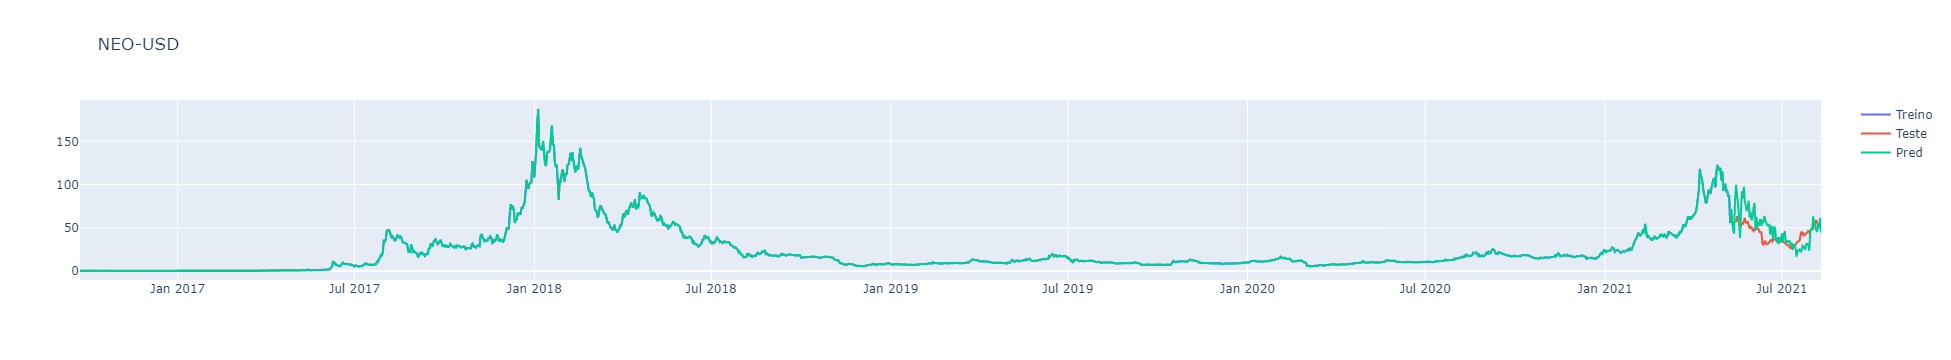


Feature importance para NEO-USD:


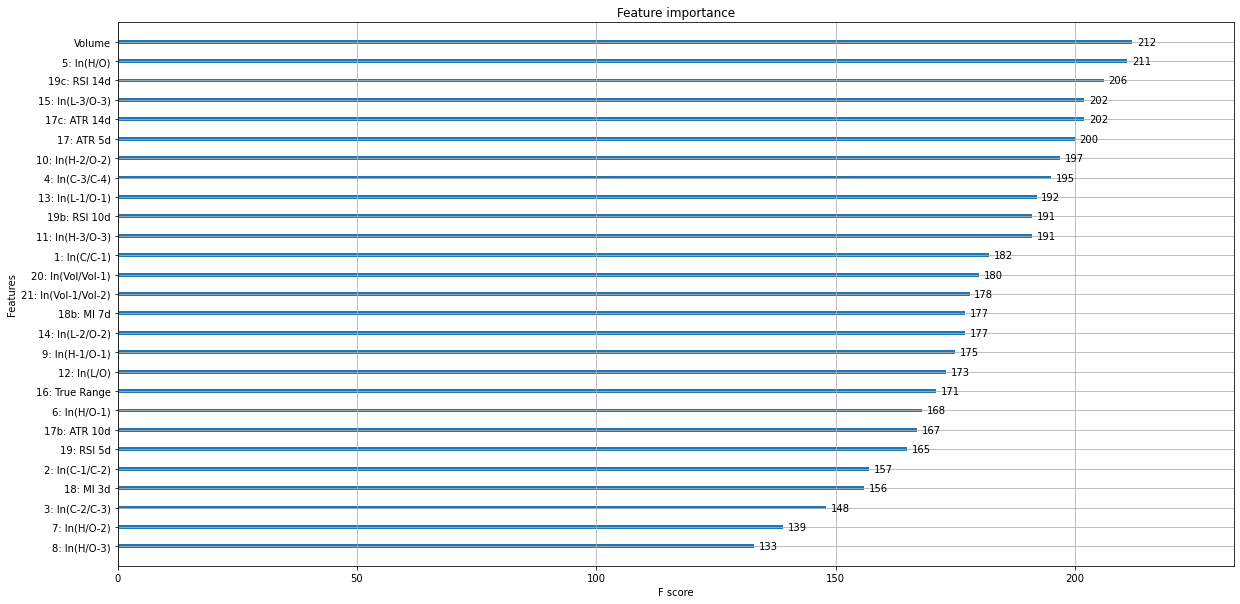


Resultados do modelo no teste para NEO-USD
MAPE = 0.3019
MSE = 16.1529
MAE = 12.8418
RMSE = 260.9174
DataFrame consolidado de melhores parâmetros e resultados por ativo até aqui:
       Ativo  learning_rate n_estimators max_depth  subsample  \
0    BTC-USD            0.5          400         3        0.8   
1   DOGE-USD            0.5          400         3        0.8   
2    XMR-USD            0.5          400         3        0.8   
3    LTC-USD            0.5           50         3        1.0   
4   DASH-USD            0.5          400         4        0.8   
5    XLM-USD            0.5           50         3        0.8   
6    XRP-USD            0.5           50         3        0.8   
7   USDT-USD            0.3           50         6        1.0   
8    ETH-USD            0.5          100         6        1.0   
9    ETC-USD            0.3          400         6        1.0   
10   NEO-USD            0.5          400         4        1.0   

    colsample_bytree min_child_weight g

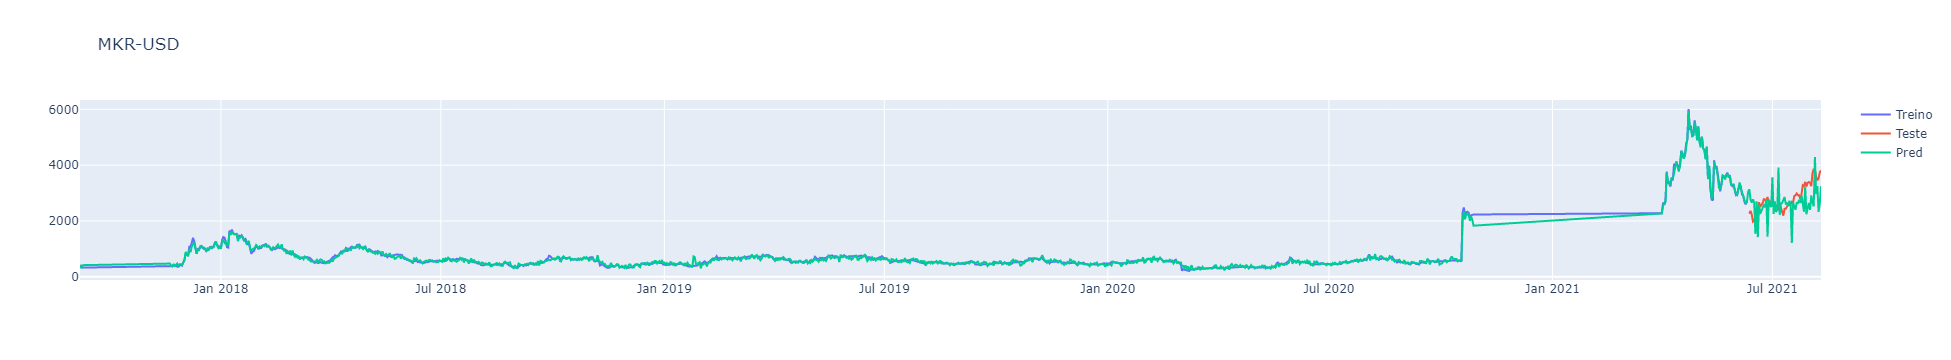


Feature importance para MKR-USD:


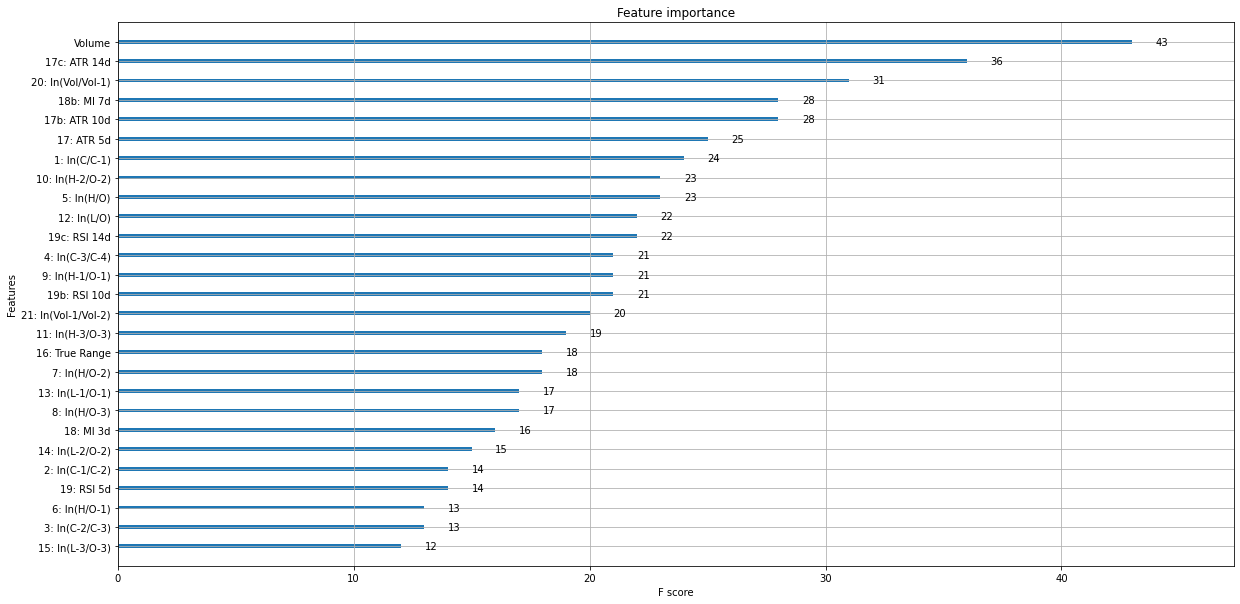


Resultados do modelo no teste para MKR-USD
MAPE = 0.1742
MSE = 636.5718
MAE = 491.2590
RMSE = 405223.6839
DataFrame consolidado de melhores parâmetros e resultados por ativo até aqui:
       Ativo  learning_rate n_estimators max_depth  subsample  \
0    BTC-USD            0.5          400         3        0.8   
1   DOGE-USD            0.5          400         3        0.8   
2    XMR-USD            0.5          400         3        0.8   
3    LTC-USD            0.5           50         3        1.0   
4   DASH-USD            0.5          400         4        0.8   
5    XLM-USD            0.5           50         3        0.8   
6    XRP-USD            0.5           50         3        0.8   
7   USDT-USD            0.3           50         6        1.0   
8    ETH-USD            0.5          100         6        1.0   
9    ETC-USD            0.3          400         6        1.0   
10   NEO-USD            0.5          400         4        1.0   
11   MKR-USD            0.5        

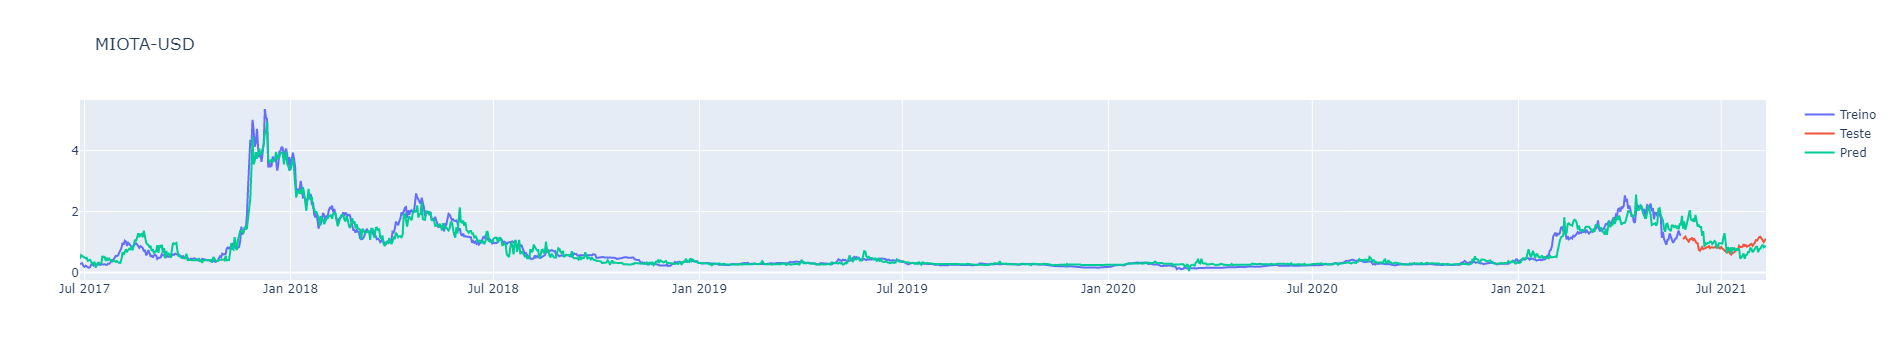


Feature importance para MIOTA-USD:


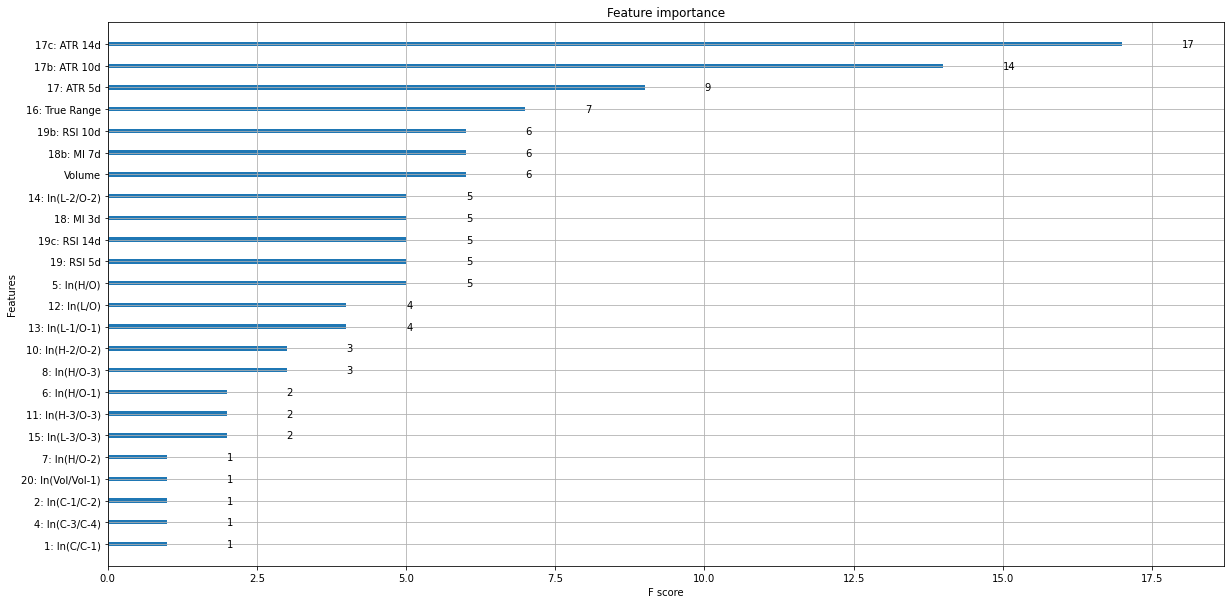


Resultados do modelo no teste para MIOTA-USD
MAPE = 0.3309
MSE = 0.3813
MAE = 0.3017
RMSE = 0.1454
DataFrame consolidado de melhores parâmetros e resultados por ativo até aqui:
        Ativo  learning_rate n_estimators max_depth  subsample  \
0     BTC-USD            0.5          400         3        0.8   
1    DOGE-USD            0.5          400         3        0.8   
2     XMR-USD            0.5          400         3        0.8   
3     LTC-USD            0.5           50         3        1.0   
4    DASH-USD            0.5          400         4        0.8   
5     XLM-USD            0.5           50         3        0.8   
6     XRP-USD            0.5           50         3        0.8   
7    USDT-USD            0.3           50         6        1.0   
8     ETH-USD            0.5          100         6        1.0   
9     ETC-USD            0.3          400         6        1.0   
10    NEO-USD            0.5          400         4        1.0   
11    MKR-USD            0.5  

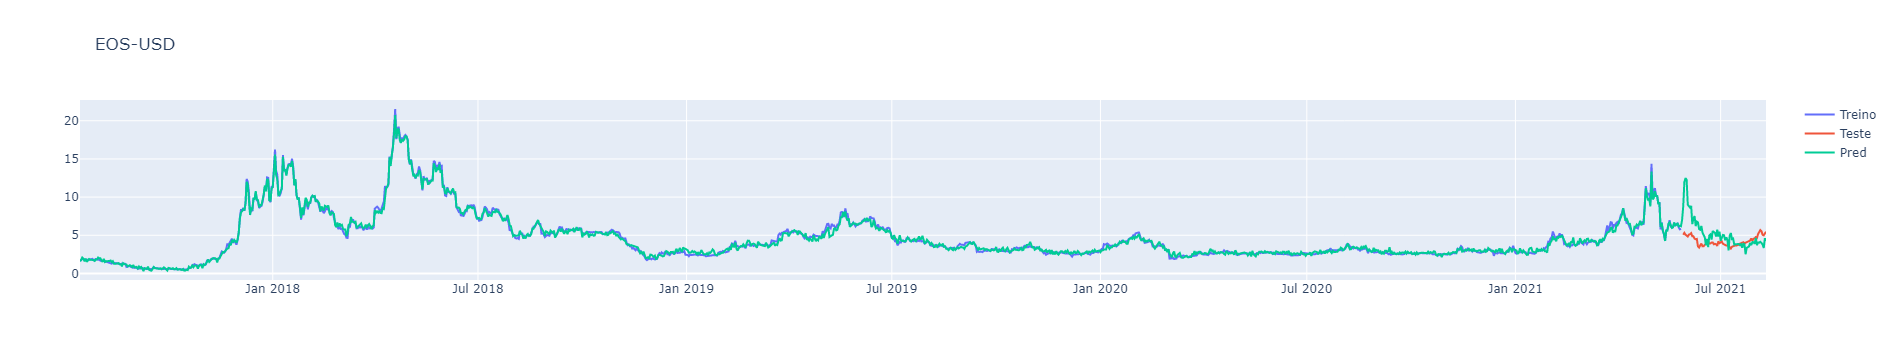


Feature importance para EOS-USD:


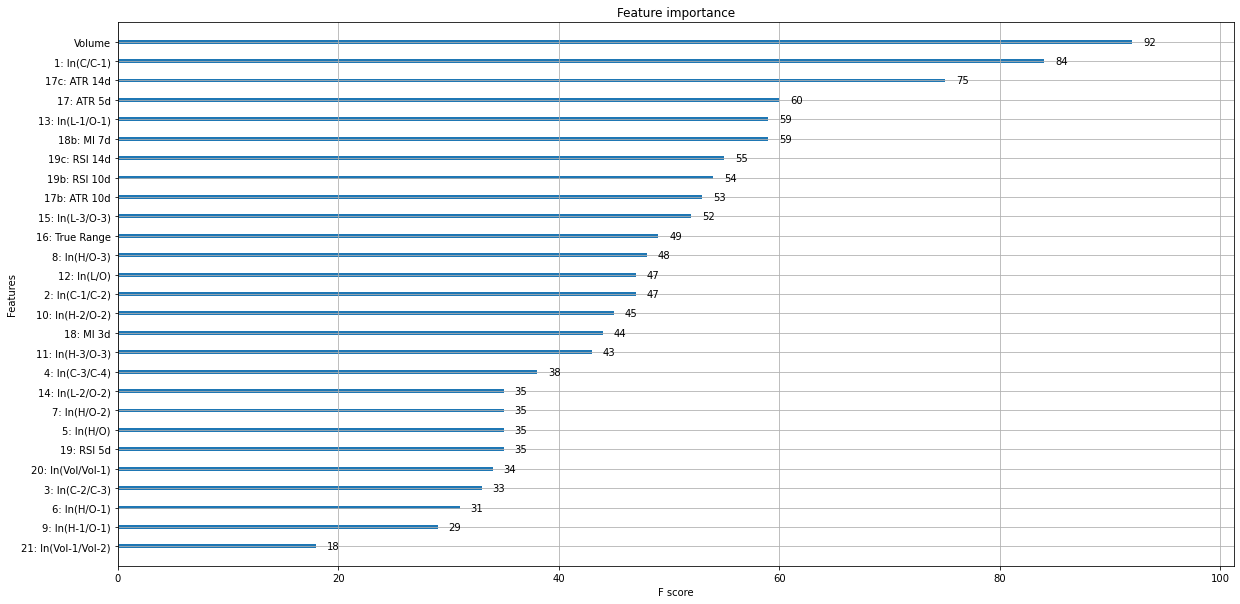


Resultados do modelo no teste para EOS-USD
MAPE = 0.3374
MSE = 2.1207
MAE = 1.4826
RMSE = 4.4974
DataFrame consolidado de melhores parâmetros e resultados por ativo até aqui:
        Ativo  learning_rate n_estimators max_depth  subsample  \
0     BTC-USD            0.5          400         3        0.8   
1    DOGE-USD            0.5          400         3        0.8   
2     XMR-USD            0.5          400         3        0.8   
3     LTC-USD            0.5           50         3        1.0   
4    DASH-USD            0.5          400         4        0.8   
5     XLM-USD            0.5           50         3        0.8   
6     XRP-USD            0.5           50         3        0.8   
7    USDT-USD            0.3           50         6        1.0   
8     ETH-USD            0.5          100         6        1.0   
9     ETC-USD            0.3          400         6        1.0   
10    NEO-USD            0.5          400         4        1.0   
11    MKR-USD            0.5    

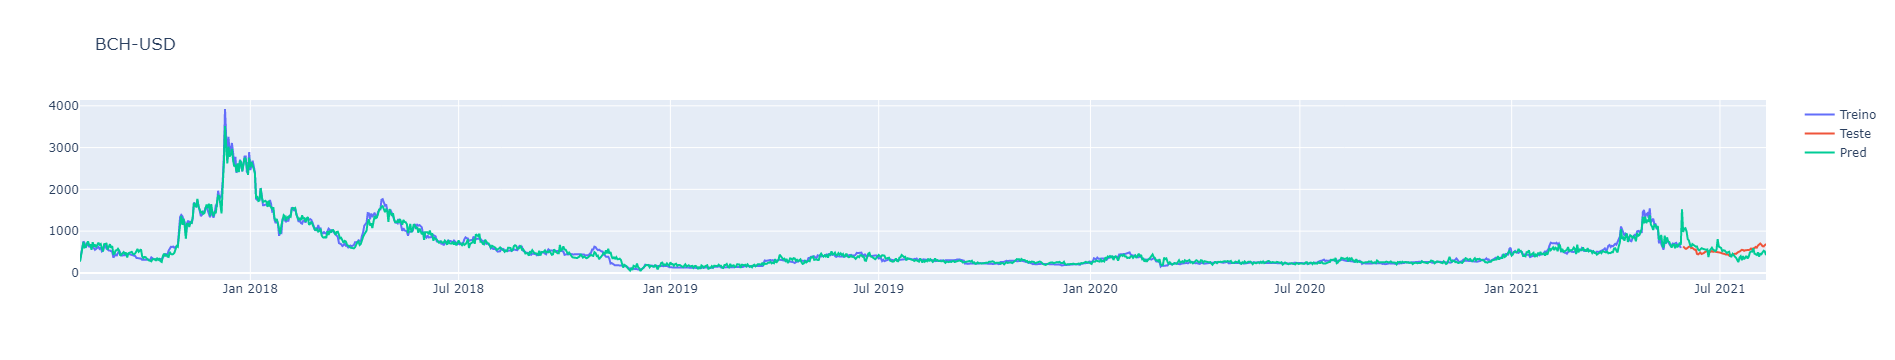


Feature importance para BCH-USD:


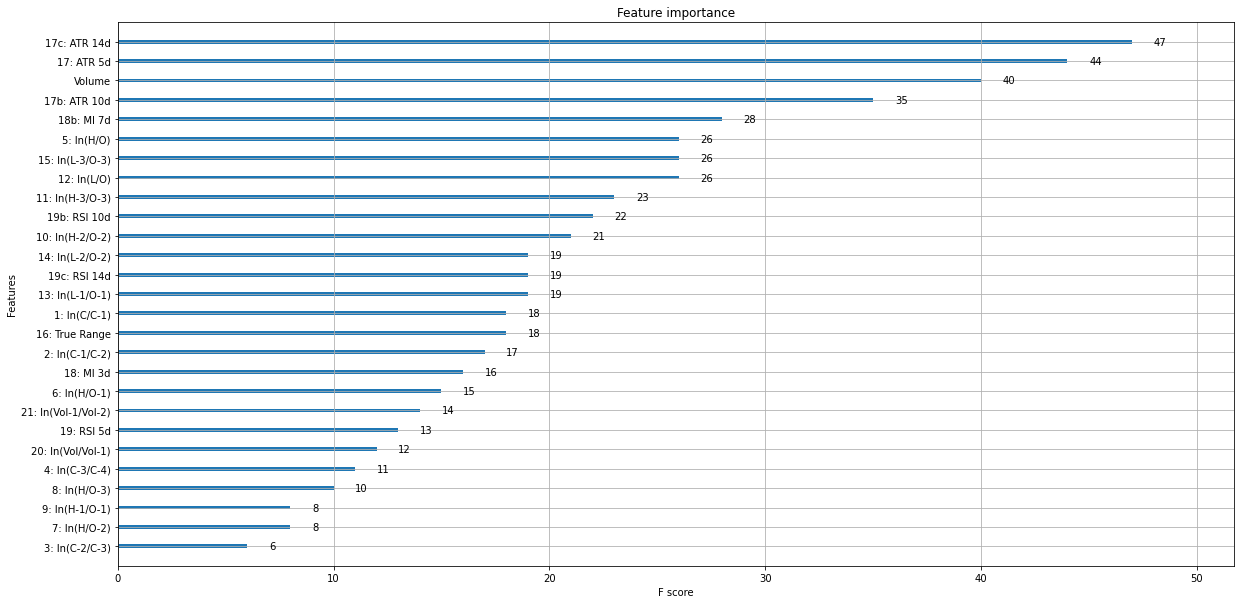


Resultados do modelo no teste para BCH-USD
MAPE = 0.2342
MSE = 163.6862
MAE = 129.1379
RMSE = 26793.1654
DataFrame consolidado de melhores parâmetros e resultados por ativo até aqui:
        Ativo  learning_rate n_estimators max_depth  subsample  \
0     BTC-USD            0.5          400         3        0.8   
1    DOGE-USD            0.5          400         3        0.8   
2     XMR-USD            0.5          400         3        0.8   
3     LTC-USD            0.5           50         3        1.0   
4    DASH-USD            0.5          400         4        0.8   
5     XLM-USD            0.5           50         3        0.8   
6     XRP-USD            0.5           50         3        0.8   
7    USDT-USD            0.3           50         6        1.0   
8     ETH-USD            0.5          100         6        1.0   
9     ETC-USD            0.3          400         6        1.0   
10    NEO-USD            0.5          400         4        1.0   
11    MKR-USD           

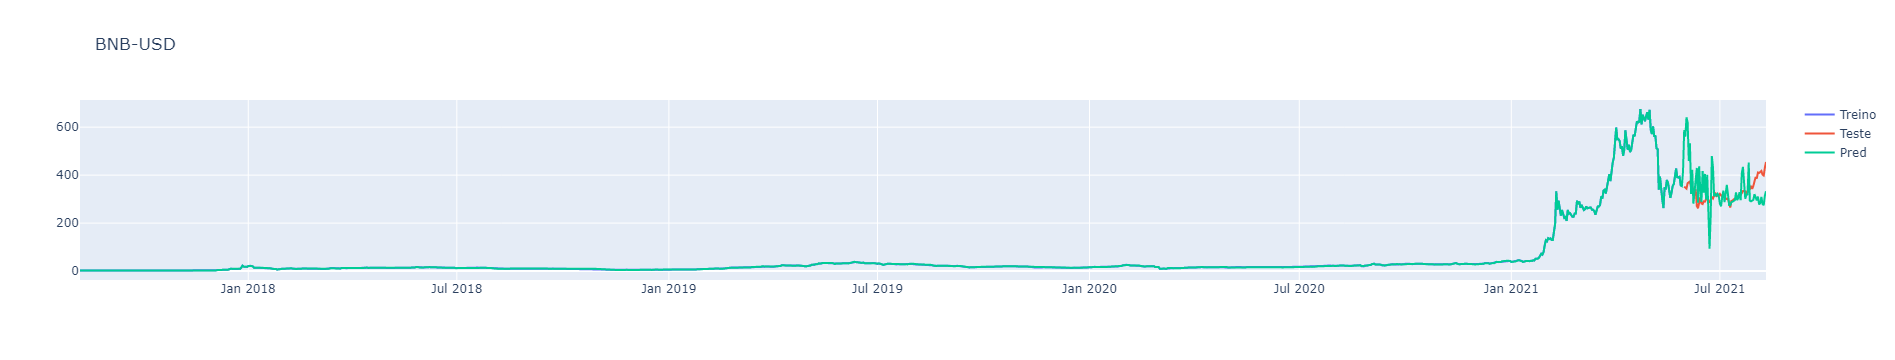


Feature importance para BNB-USD:


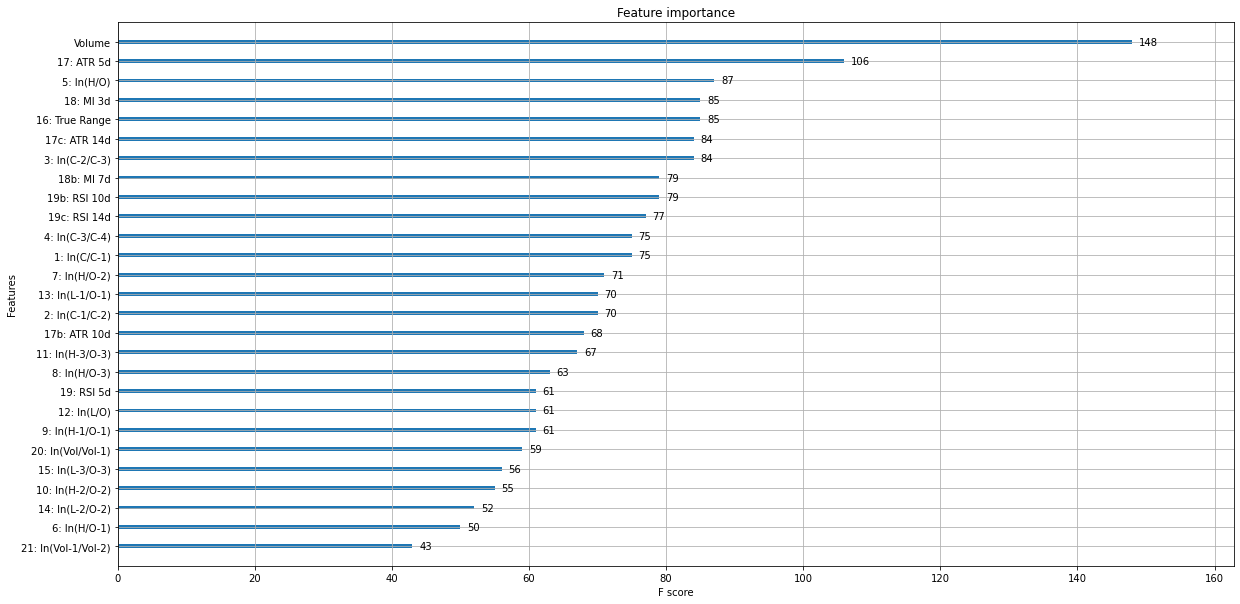


Resultados do modelo no teste para BNB-USD
MAPE = 0.2038
MSE = 96.5205
MAE = 69.0894
RMSE = 9316.2051
DataFrame consolidado de melhores parâmetros e resultados por ativo até aqui:
        Ativo  learning_rate n_estimators max_depth  subsample  \
0     BTC-USD            0.5          400         3        0.8   
1    DOGE-USD            0.5          400         3        0.8   
2     XMR-USD            0.5          400         3        0.8   
3     LTC-USD            0.5           50         3        1.0   
4    DASH-USD            0.5          400         4        0.8   
5     XLM-USD            0.5           50         3        0.8   
6     XRP-USD            0.5           50         3        0.8   
7    USDT-USD            0.3           50         6        1.0   
8     ETH-USD            0.5          100         6        1.0   
9     ETC-USD            0.3          400         6        1.0   
10    NEO-USD            0.5          400         4        1.0   
11    MKR-USD            0.

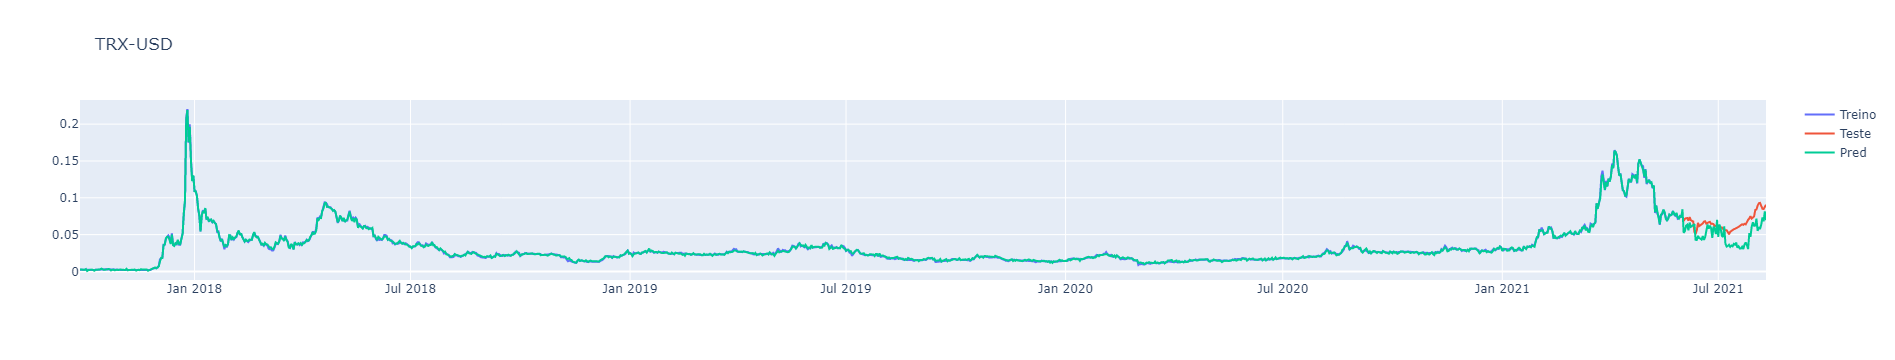


Feature importance para TRX-USD:


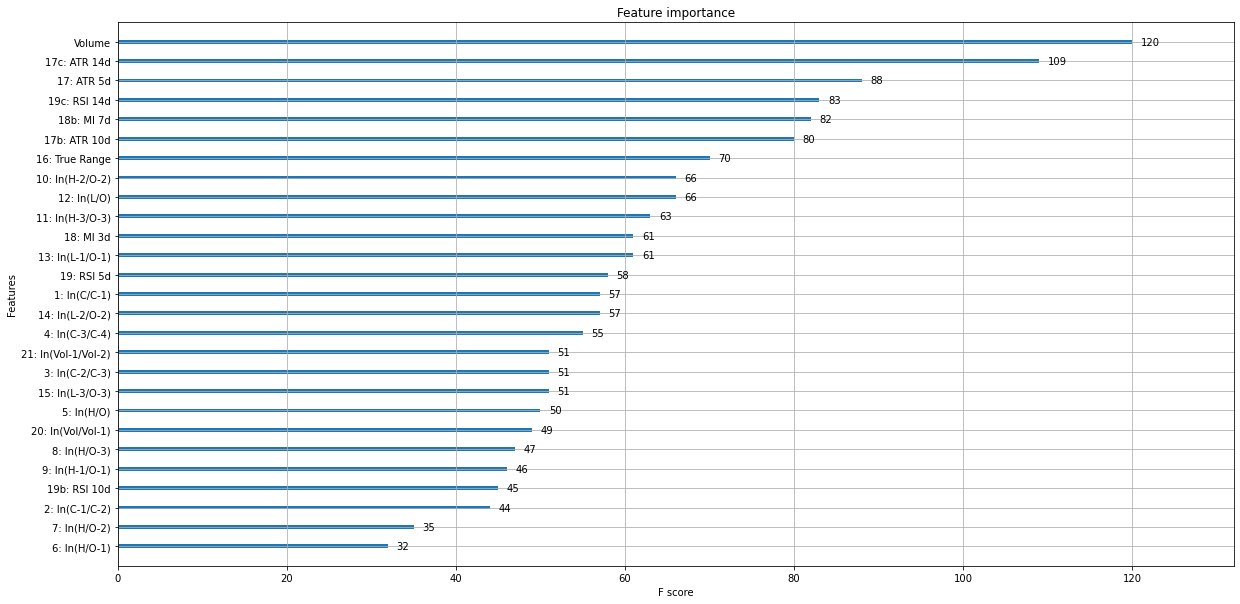


Resultados do modelo no teste para TRX-USD
MAPE = 0.2545
MSE = 0.0193
MAE = 0.0169
RMSE = 0.0004
DataFrame consolidado de melhores parâmetros e resultados por ativo até aqui:
        Ativo  learning_rate n_estimators max_depth  subsample  \
0     BTC-USD            0.5          400         3        0.8   
1    DOGE-USD            0.5          400         3        0.8   
2     XMR-USD            0.5          400         3        0.8   
3     LTC-USD            0.5           50         3        1.0   
4    DASH-USD            0.5          400         4        0.8   
5     XLM-USD            0.5           50         3        0.8   
6     XRP-USD            0.5           50         3        0.8   
7    USDT-USD            0.3           50         6        1.0   
8     ETH-USD            0.5          100         6        1.0   
9     ETC-USD            0.3          400         6        1.0   
10    NEO-USD            0.5          400         4        1.0   
11    MKR-USD            0.5    

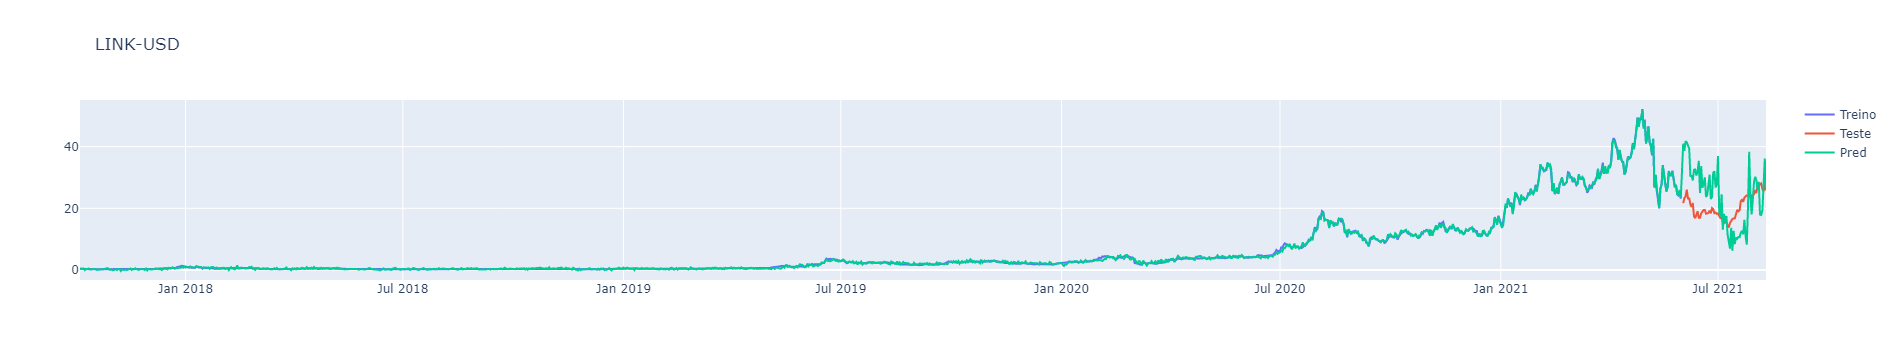


Feature importance para LINK-USD:


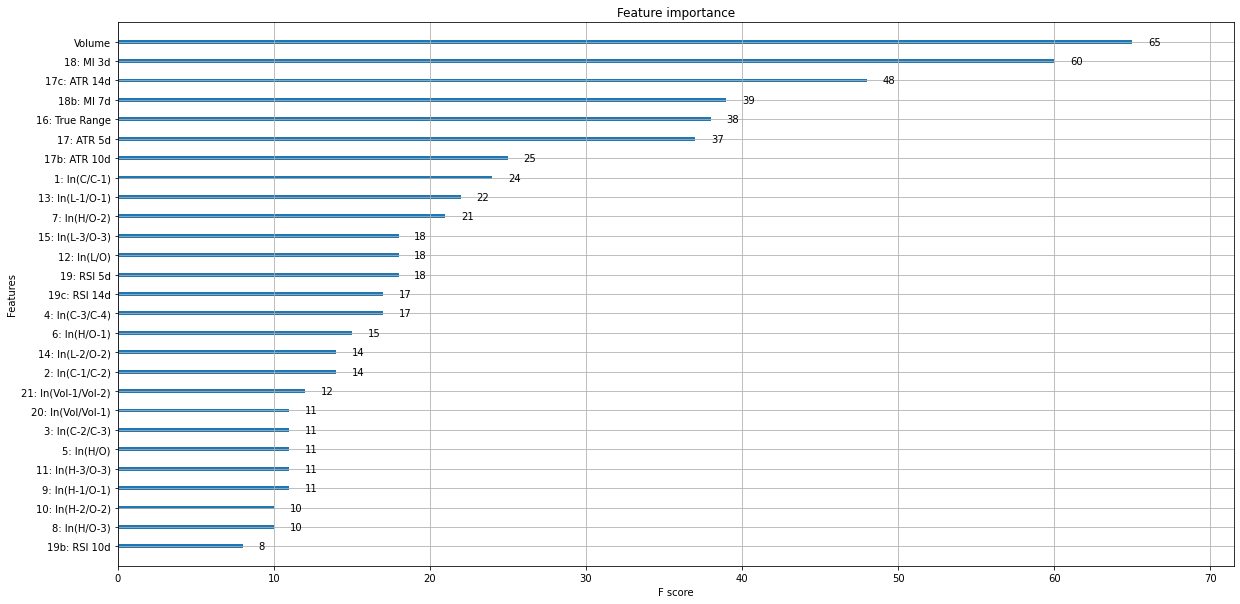


Resultados do modelo no teste para LINK-USD
MAPE = 0.4202
MSE = 9.9161
MAE = 8.4811
RMSE = 98.3299
DataFrame consolidado de melhores parâmetros e resultados por ativo até aqui:
        Ativo  learning_rate n_estimators max_depth  subsample  \
0     BTC-USD            0.5          400         3        0.8   
1    DOGE-USD            0.5          400         3        0.8   
2     XMR-USD            0.5          400         3        0.8   
3     LTC-USD            0.5           50         3        1.0   
4    DASH-USD            0.5          400         4        0.8   
5     XLM-USD            0.5           50         3        0.8   
6     XRP-USD            0.5           50         3        0.8   
7    USDT-USD            0.3           50         6        1.0   
8     ETH-USD            0.5          100         6        1.0   
9     ETC-USD            0.3          400         6        1.0   
10    NEO-USD            0.5          400         4        1.0   
11    MKR-USD            0.5  

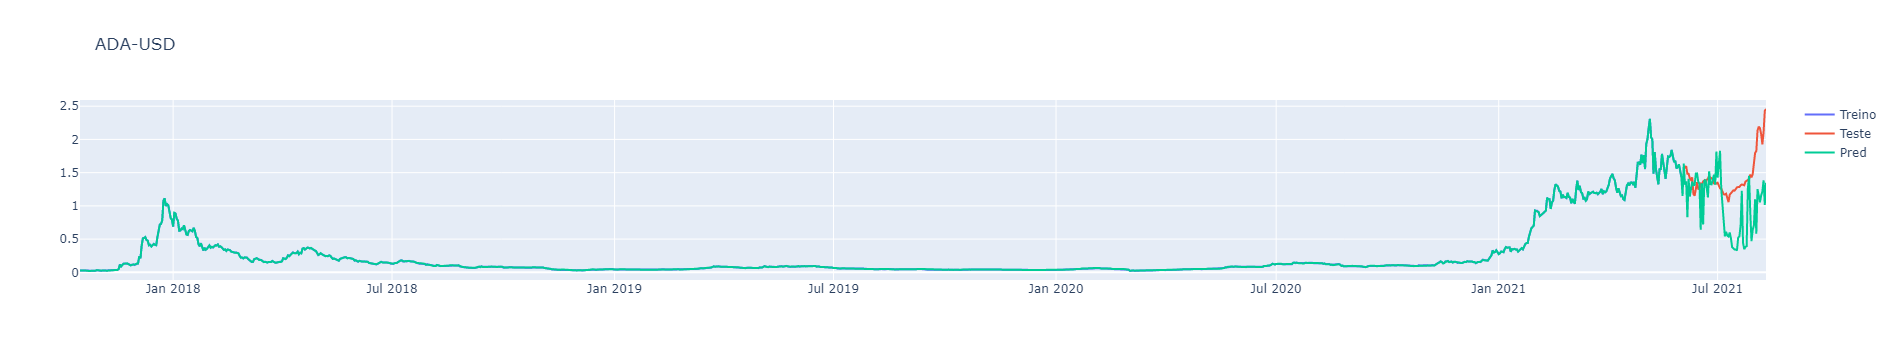


Feature importance para ADA-USD:


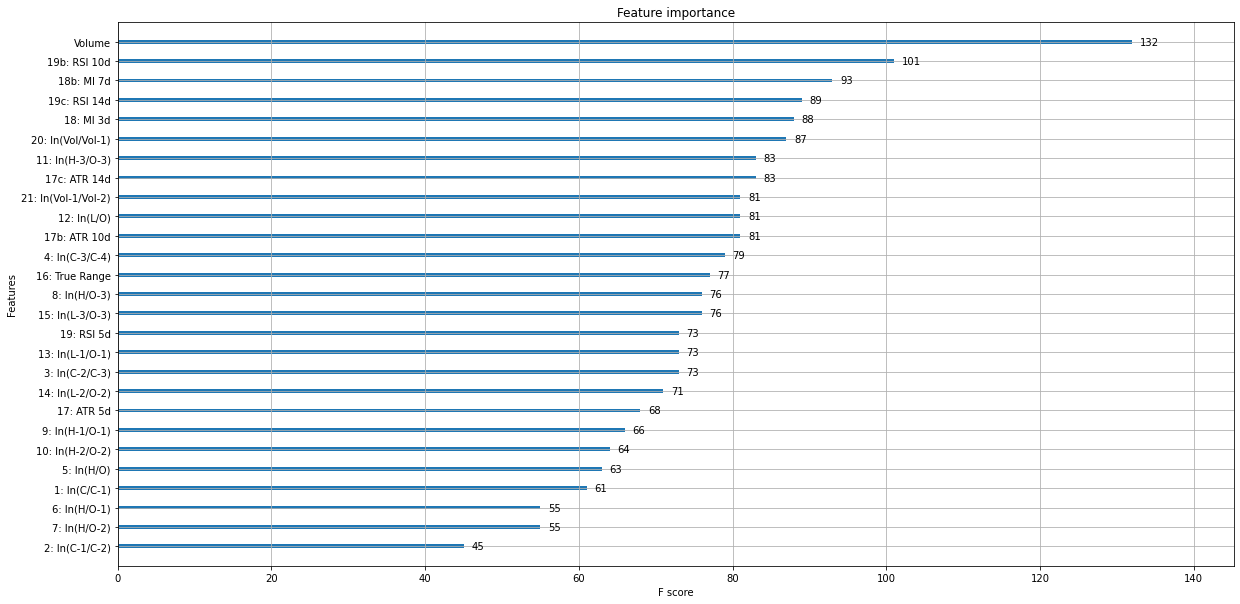


Resultados do modelo no teste para ADA-USD
MAPE = 0.3396
MSE = 0.6275
MAE = 0.4989
RMSE = 0.3937
DataFrame consolidado de melhores parâmetros e resultados por ativo até aqui:
        Ativo  learning_rate n_estimators max_depth  subsample  \
0     BTC-USD            0.5          400         3        0.8   
1    DOGE-USD            0.5          400         3        0.8   
2     XMR-USD            0.5          400         3        0.8   
3     LTC-USD            0.5           50         3        1.0   
4    DASH-USD            0.5          400         4        0.8   
5     XLM-USD            0.5           50         3        0.8   
6     XRP-USD            0.5           50         3        0.8   
7    USDT-USD            0.3           50         6        1.0   
8     ETH-USD            0.5          100         6        1.0   
9     ETC-USD            0.3          400         6        1.0   
10    NEO-USD            0.5          400         4        1.0   
11    MKR-USD            0.5    

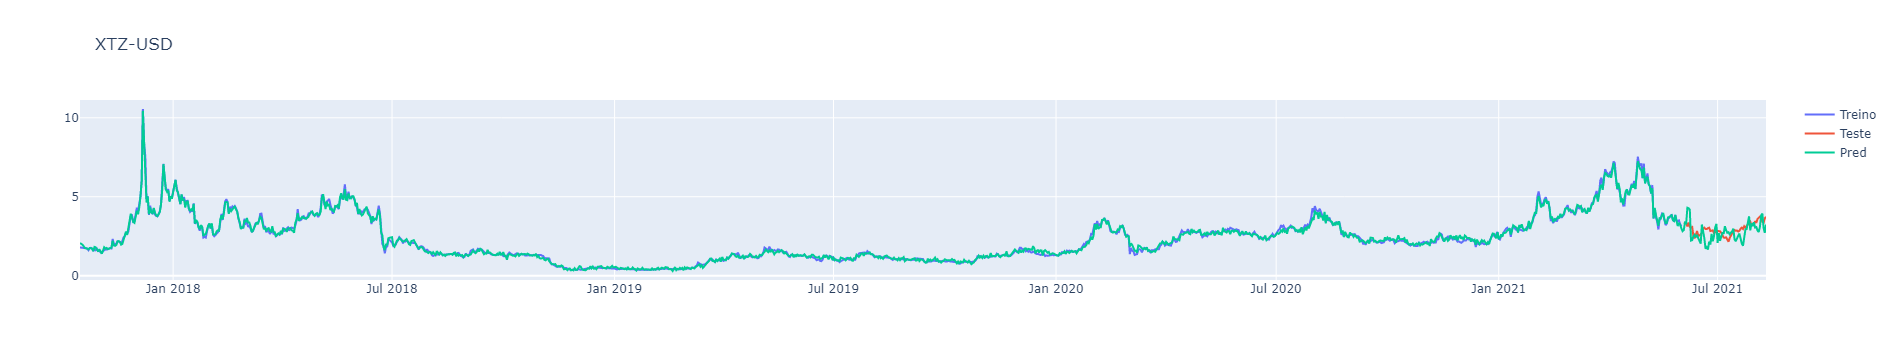


Feature importance para XTZ-USD:


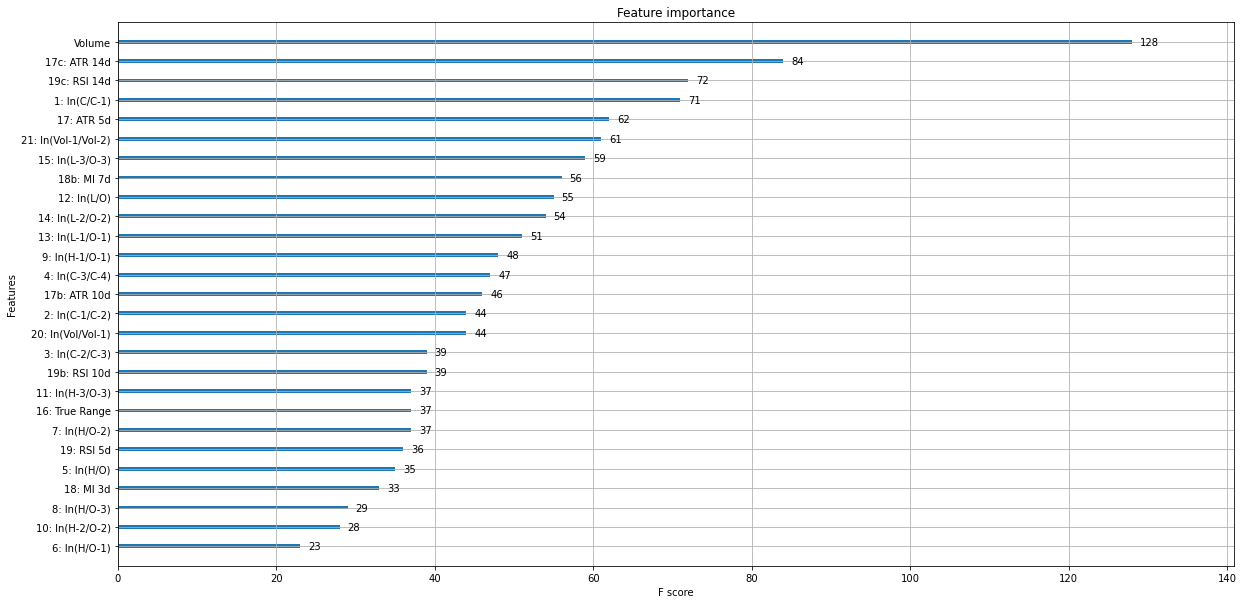


Resultados do modelo no teste para XTZ-USD
MAPE = 0.1639
MSE = 0.5918
MAE = 0.4874
RMSE = 0.3502
DataFrame consolidado de melhores parâmetros e resultados por ativo até aqui:
        Ativo  learning_rate n_estimators max_depth  subsample  \
0     BTC-USD            0.5          400         3        0.8   
1    DOGE-USD            0.5          400         3        0.8   
2     XMR-USD            0.5          400         3        0.8   
3     LTC-USD            0.5           50         3        1.0   
4    DASH-USD            0.5          400         4        0.8   
5     XLM-USD            0.5           50         3        0.8   
6     XRP-USD            0.5           50         3        0.8   
7    USDT-USD            0.3           50         6        1.0   
8     ETH-USD            0.5          100         6        1.0   
9     ETC-USD            0.3          400         6        1.0   
10    NEO-USD            0.5          400         4        1.0   
11    MKR-USD            0.5    

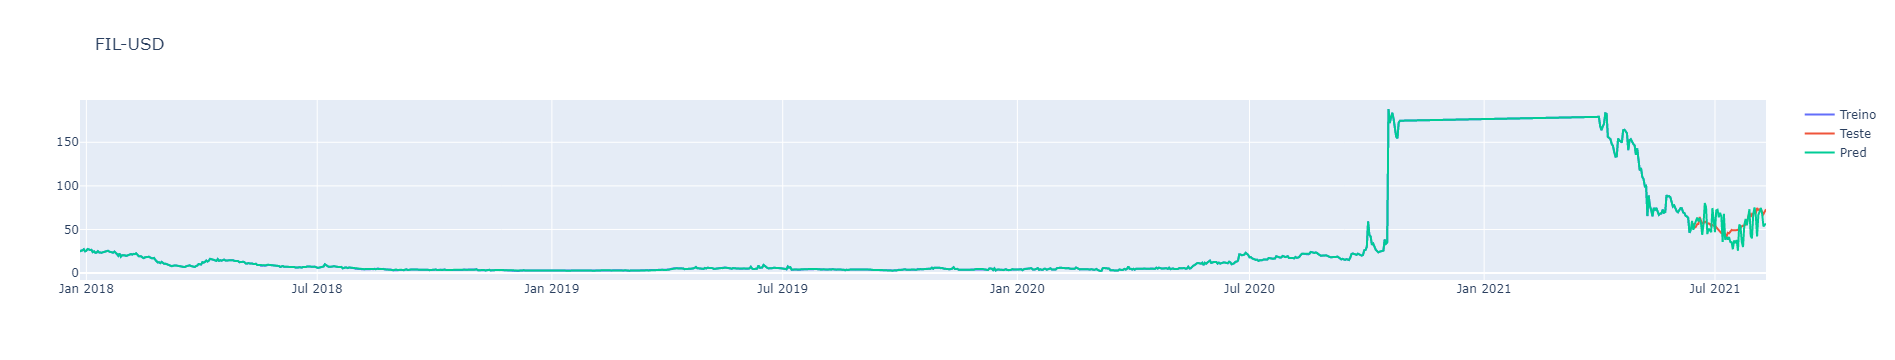


Feature importance para FIL-USD:


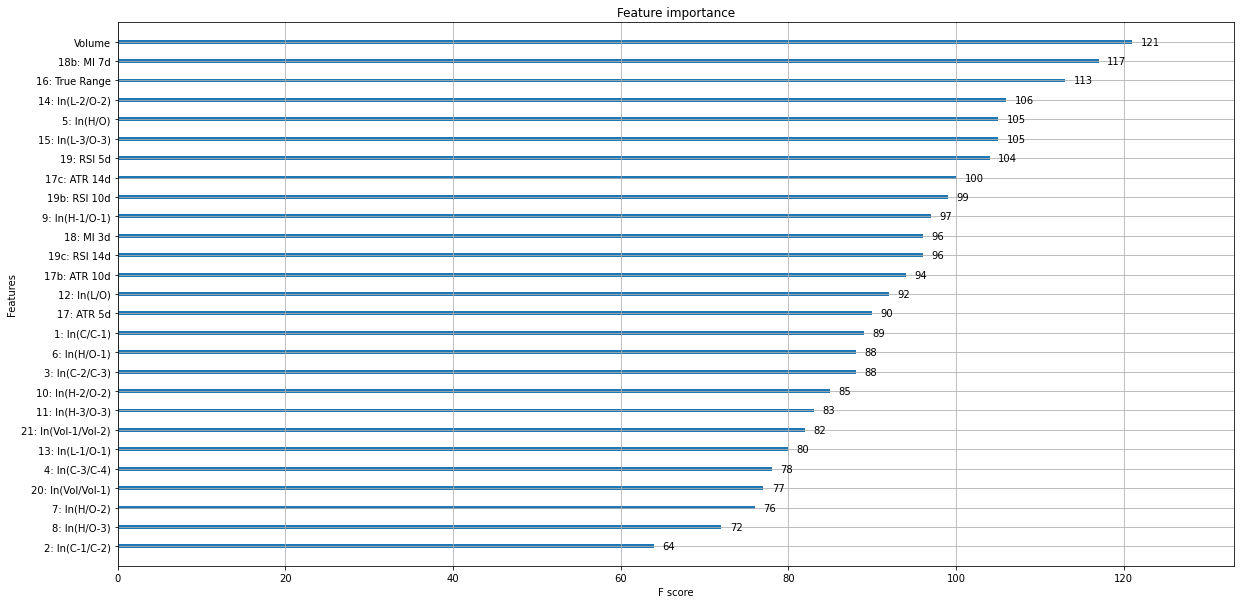


Resultados do modelo no teste para FIL-USD
MAPE = 0.1918
MSE = 13.3699
MAE = 10.5740
RMSE = 178.7534
DataFrame consolidado de melhores parâmetros e resultados por ativo até aqui:
        Ativo  learning_rate n_estimators max_depth  subsample  \
0     BTC-USD            0.5          400         3        0.8   
1    DOGE-USD            0.5          400         3        0.8   
2     XMR-USD            0.5          400         3        0.8   
3     LTC-USD            0.5           50         3        1.0   
4    DASH-USD            0.5          400         4        0.8   
5     XLM-USD            0.5           50         3        0.8   
6     XRP-USD            0.5           50         3        0.8   
7    USDT-USD            0.3           50         6        1.0   
8     ETH-USD            0.5          100         6        1.0   
9     ETC-USD            0.3          400         6        1.0   
10    NEO-USD            0.5          400         4        1.0   
11    MKR-USD            0.5

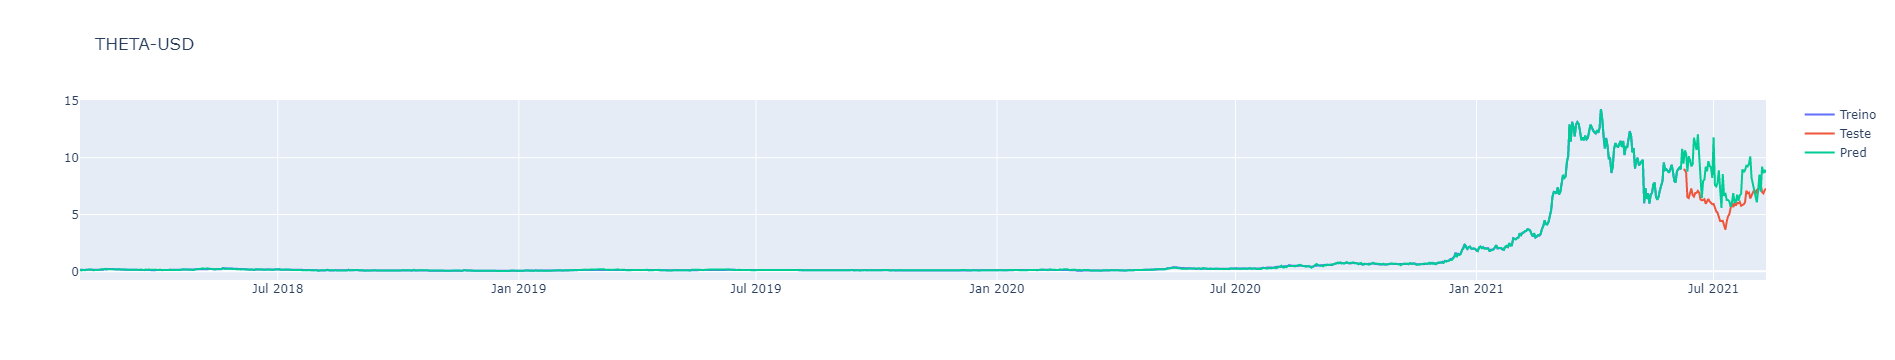


Feature importance para THETA-USD:


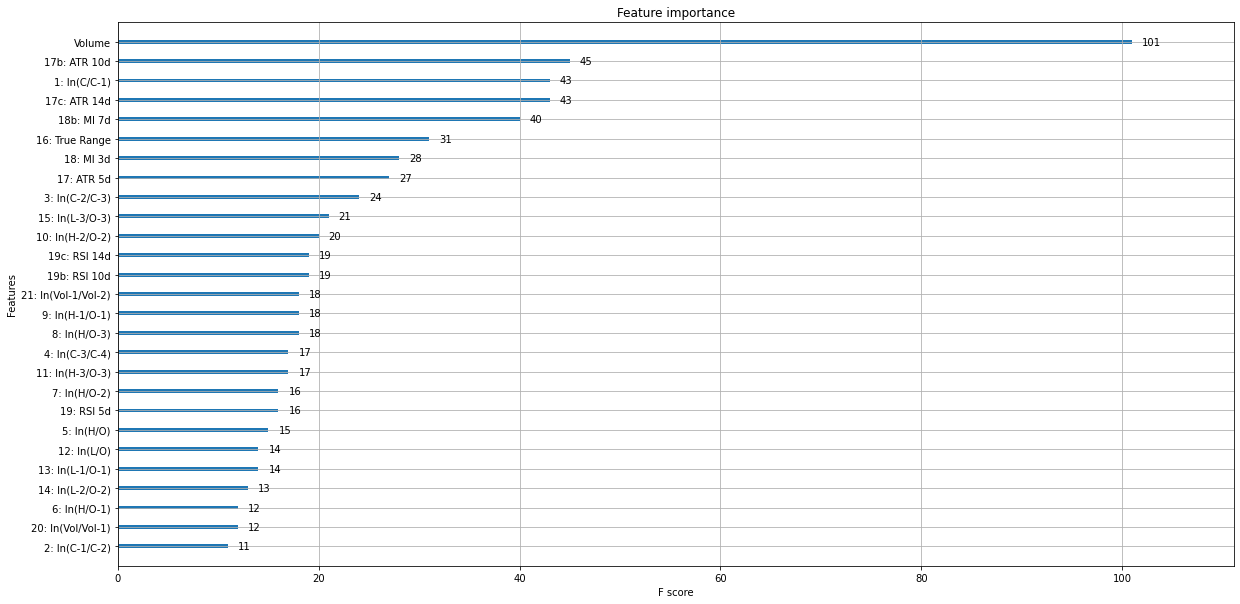


Resultados do modelo no teste para THETA-USD
MAPE = 0.3479
MSE = 2.4802
MAE = 2.0805
RMSE = 6.1512
DataFrame consolidado de melhores parâmetros e resultados por ativo até aqui:
        Ativo  learning_rate n_estimators max_depth  subsample  \
0     BTC-USD            0.5          400         3        0.8   
1    DOGE-USD            0.5          400         3        0.8   
2     XMR-USD            0.5          400         3        0.8   
3     LTC-USD            0.5           50         3        1.0   
4    DASH-USD            0.5          400         4        0.8   
5     XLM-USD            0.5           50         3        0.8   
6     XRP-USD            0.5           50         3        0.8   
7    USDT-USD            0.3           50         6        1.0   
8     ETH-USD            0.5          100         6        1.0   
9     ETC-USD            0.3          400         6        1.0   
10    NEO-USD            0.5          400         4        1.0   
11    MKR-USD            0.5  

In [ ]:
for crypto in ativos[10:]:
    model_crypto(crypto, df_ativos, df_models_rev4)

In [ ]:
ativos[10:]

['NEO-USD',
 'MKR-USD',
 'MIOTA-USD',
 'EOS-USD',
 'BCH-USD',
 'BNB-USD',
 'TRX-USD',
 'LINK-USD',
 'ADA-USD',
 'XTZ-USD',
 'FIL-USD',
 'THETA-USD']

In [ ]:
df_models

Ativo learning_rate n_estimators max_depth  subsample  \
0     BTC-USD             1          500         2        0.7   
1    DOGE-USD           0.5          700         5        0.9   
2     XMR-USD           0.3          700         2        0.9   
3     LTC-USD           0.3          500         4        0.7   
4    DASH-USD           0.3          100         3        0.7   
5     XLM-USD           0.3          700         2        0.7   
6     XRP-USD           0.3          300         4        0.5   
7    USDT-USD           0.3          100         4        0.9   
8     ETH-USD           0.5          100         2        0.7   
9     ETC-USD           0.3          100         5        0.9   
10    NEO-USD           0.5          300         4        0.9   
11    MKR-USD           0.3          100         5        0.9   
12  MIOTA-USD           0.3          700         4        0.7   
13    EOS-USD           0.3          100         2        0.7   
14    BCH-USD           0.5          100         2        0.9   
15    BNB-USD           0.5          300         4        0.5   
16    TRX-USD           0.3          700         5        0.9   
17   LINK-USD           0.7          500         3        0.7   
18    ADA-USD           0.5          500         2        0.7   
19    XTZ-USD           0.3          700         2        0.9   
20    FIL-USD           0.3          300         3        0.7   
21  THETA-USD             1          700         2        0.9   

   min_child_weight  reg_alpha reg_lambda  MAPE_test      MSE_test  \
0                 1     0.0010          1   0.353602  16778.139882   
1                 1     0.0010    0.00001   0.756510      0.263525   
2                 1     0.0010       0.05   0.180541     69.034018   
3                 5     0.0000       0.01   0.236362     58.466991   
4                 3     0.0010       0.01   0.495103    151.341533   
5                 1     0.0010       0.01   0.275040      0.116961   
6                 3     0.0001       0.01   0.253284      0.440900   
7                 1     0.0001    0.00001   0.001026      0.002006   
8                 3     0.0000       0.01   0.216558    706.728446   
9                 3     0.0000    0.00001   0.498553     32.496405   
10                5     0.0010    0.00001   0.423561     24.169547   
11                3     0.0010    0.00001   0.227928    721.187129   
12                7     0.0010       0.05   0.324269      0.351800   
13                1     0.0001          1   0.271242      1.676081   
14                7     0.0010          1   0.293597    192.502994   
15                1     0.0000    0.00001   0.278235    108.225960   
16                1     0.0001       0.05   0.272579      0.022290   
17                1     0.0010    0.00001   0.470098     11.162152   
18                3     0.0010          1   0.284688      0.543267   
19                5     0.0010          1   0.164894      0.592129   
20                1     0.0010    0.00001   0.143712     10.819323   
21                1     0.0001       0.05   0.462268      3.305532   

        MAE_test     RMSE_test  
0   14105.568586  2.815060e+08  
1       0.237696  6.944549e-02  
2      53.212467  4.765696e+03  
3      46.680192  3.418389e+03  
4      96.785548  2.290426e+04  
5       0.096830  1.367983e-02  
6       0.271676  1.943924e-01  
7       0.001027  4.022939e-06  
8     575.899718  4.994651e+05  
9      24.093858  1.056016e+03  
10     18.502235  5.841670e+02  
11    580.447943  5.201109e+05  
12      0.295870  1.237635e-01  
13      1.190120  2.809247e+00  
14    158.829745  3.705740e+04  
15     91.857276  1.171286e+04  
16      0.018730  4.968590e-04  
17      9.242402  1.245936e+02  
18      0.421065  2.951388e-01  
19      0.485007  3.506162e-01  
20      8.317263  1.170578e+02  
21      2.683569  1.092654e+01

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 3
min_resources_: 100
max_resources_: 2376
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 7
n_resources: 100
Fitting 4 folds for each of 7 candidates, totalling 28 fits
----------
iter: 1
n_candidates: 3
n_resources: 300
Fitting 4 folds for each of 3 candidates, totalling 12 fits


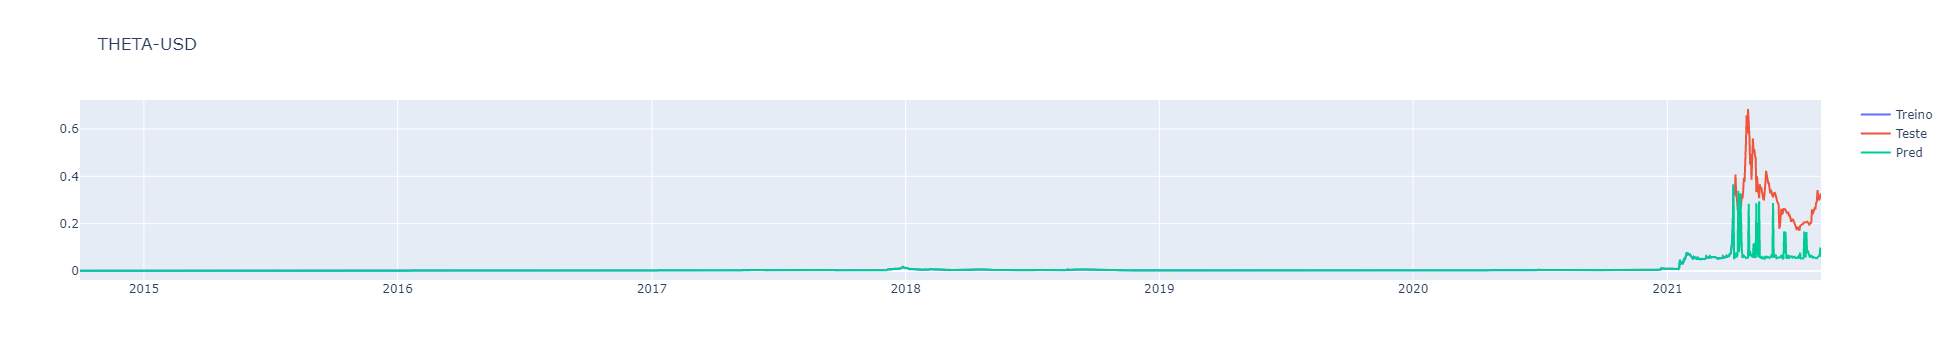


Feature importance para DOGE:


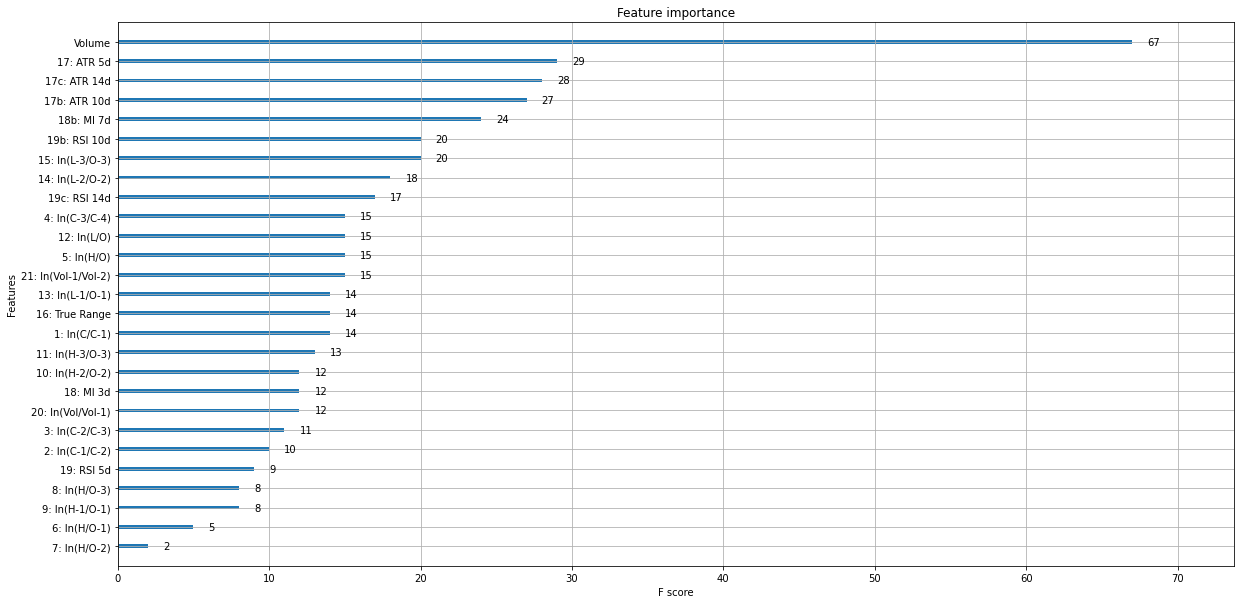


Resultados do modelo no teste para DOGE
MAPE = 0.7345


In [ ]:
#Fazendo um tira-teima com BTC:

test_size = 0.05
test_split_idx  = int(df_ativos[df_ativos['Ativo']=='DOGE-USD'].shape[0] * (1-test_size))

df_train  = df_ativos[df_ativos['Ativo']=='DOGE-USD'].iloc[:test_split_idx].copy()
df_test   = df_ativos[df_ativos['Ativo']=='DOGE-USD'].iloc[test_split_idx+1:].copy()

X_train = df_train.drop(columns=['Close','Ativo']) #df_train[lista_boruta]
X_test = df_test.drop(columns=['Close','Ativo']) #df_test[lista_boruta]

y_train = df_train['Close']
y_test = df_test['Close']

model_BTC = xgb.XGBRegressor(learning_rate = 0.5, max_depth = 5, subsample = 0.9, reg_alpha = 0.001, reg_lambda = 0.00001)

params = {'colsample_bytree': [0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1],
        #'min_child_weight': [0.01, 0.05, 0.1, 0.25, 0.5, 1, 5, 10],
          #'gamma': [0, 1, 5, 10, 20, 50],
          #'n_estimators': [50, 500, 700, 1200, 2000],
        }

ts = TimeSeriesSplit(n_splits=4)


halving = HalvingGridSearchCV(model_BTC, params, cv = ts, scoring='neg_mean_squared_error', n_jobs=-1, min_resources=100, factor=3, verbose = 4)

halving.fit(X_train, y_train)
    
melhor_modelo = halving.best_estimator_

y_pred = melhor_modelo.predict(X_test)
y_total = melhor_modelo.predict(df_ativos[df_ativos['Ativo']=='DOGE-USD'].drop(columns = ['Ativo','Close']))

fig = go.Figure(layout=go.Layout(title=go.layout.Title(text=ativo))) 
fig.add_trace(go.Scatter(x=X_train.index, y=y_train, name='Treino'))
fig.add_trace(go.Scatter(x=X_test.index,  y=y_test,  name='Teste'))
fig.add_trace(go.Scatter(x=df_ativos[df_ativos['Ativo']=='DOGE-USD'].index,  y=y_total,  name='Pred'))
fig.show()

print ("\nFeature importance para DOGE:")
plt.rcParams["figure.figsize"] = (20, 10)
plot_importance(melhor_modelo)
plt.show()

#4. Métricas de erro no teste:

MAPE_test = np.mean(np.abs((y_test - y_pred)/y_test))


print("\nResultados do modelo no teste para DOGE")
print(f'MAPE = {MAPE_test:.4f}')


In [ ]:
df_models_rev4

Ativo  learning_rate n_estimators max_depth  subsample  \
0     BTC-USD            0.5          400         3        0.8   
1    DOGE-USD            0.5          400         3        0.8   
2     XMR-USD            0.5          400         3        0.8   
3     LTC-USD            0.5           50         3        1.0   
4    DASH-USD            0.5          400         4        0.8   
5     XLM-USD            0.5           50         3        0.8   
6     XRP-USD            0.5           50         3        0.8   
7    USDT-USD            0.3           50         6        1.0   
8     ETH-USD            0.5          100         6        1.0   
9     ETC-USD            0.3          400         6        1.0   
10    NEO-USD            0.5          400         4        1.0   
11    MKR-USD            0.5          100         3        0.8   
12  MIOTA-USD            0.3           50         4        1.0   
13    EOS-USD            0.3           50         5        1.0   
14    BCH-USD            0.3           50         4        1.0   
15    BNB-USD            0.5          400         4        0.8   
16    TRX-USD            0.3          100         5        1.0   
17   LINK-USD            0.5          100         3        0.8   
18    ADA-USD            0.5          400         4        1.0   
19    XTZ-USD            0.3          100         4        0.8   
20    FIL-USD            0.5          400         3        1.0   
21  THETA-USD            0.5           50         4        0.8   

    colsample_bytree min_child_weight gamma  reg_alpha  reg_lambda  MAPE_test  \
0                0.5                5     1     0.0001      0.0100   0.249453   
1                0.5              0.5     0     0.0000      1.0000   0.779242   
2                1.0                5     0     0.0100      0.0100   0.194250   
3                0.5              0.5     0     0.0000      0.0001   0.229049   
4                1.0              0.5     1     0.0000      0.0100   0.523825   
5                0.8              0.5     0     0.0100      0.0100   0.295176   
6                0.5              0.5     0     0.0001      1.0000   0.271004   
7                1.0                5     0     0.0001      1.0000   0.000711   
8                1.0              0.5     0     0.0001      1.0000   0.219183   
9                1.0              0.5     0     0.0001      1.0000   0.604364   
10               0.5                5     0     0.0001      1.0000   0.301914   
11               0.5               10     0     0.0100      0.0100   0.174229   
12               0.5                5     1     0.0100      0.0001   0.330861   
13               0.5              0.5     0     0.0100      1.0000   0.337374   
14               0.5                5     1     0.0100      1.0000   0.234219   
15               0.5              0.5     1     0.0000      0.0001   0.203836   
16               0.5               10     0     0.0001      0.0100   0.254501   
17               0.5              0.5     1     0.0000      0.0001   0.420155   
18               1.0                5     0     0.0100      0.0001   0.339629   
19               0.8              0.5     0     0.0000      1.0000   0.163856   
20               0.8                5     0     0.0000      0.0001   0.191800   
21               0.8              0.5     0     0.0000      0.0100   0.347898   

        MSE_test     MAE_test     RMSE_test  
0   11612.339545  9676.089070  1.348464e+08  
1       0.269767     0.245603  7.277413e-02  
2      71.630218    55.249887  5.130888e+03  
3      59.739026    45.508451  3.568751e+03  
4     161.919757   102.575392  2.621801e+04  
5       0.132838     0.106869  1.764600e-02  
6       0.409900     0.276322  1.680181e-01  
7       0.000877     0.000711  7.685853e-07  
8     798.833288   608.765842  6.381346e+05  
9      35.616277    30.261774  1.268519e+03  
10     16.152938    12.841842  2.609174e+02  
11    636.571821   491.259017  4.052237e+05  
12      0.381296     0.3016

In [ ]:
df_models_rev4.drop(10,inplace=True)